<center><img src="https://www.sysmex.co.uk/fileadmin/_processed_/a/9/csm_LifeScience_StageImage_BreastCancer_1500x600-01_2498abd1e0.jpg" width="720"></center>



<center><font size=6>Breast Cancer Survival Analysis</font></center>


## Problem Statement

Cancer is the second leading cause of death in the United States, with breast cancer being the most commonly diagnosed cancer [1]. In 2021, the incidence rate of new breast cancer cases was 133.8 per 100,000 people, highlighting the critical challenge posed by the disease [2]. This dataset provides real-world data on breast cancer patients, specifically those diagnosed with infiltrating duct and lobular carcinoma between 2006 and 2010. The data comes from the November 2017 update of the SEER Program (Surveillance, Epidemiology, and End Results) of the National Cancer Institute (NCI) and includes clinical and demographic information for 4,024 female patients.

By analyzing this dataset, we aim to gain insights into the factors influencing breast cancer prognosis, using various machine learning and deep learning models. Such analysis can help inform predictive modeling, guide treatment decisions, and improve early detection strategies.


References:
1. Holland, K. (2018, November). What Are the 12 Leading Causes of Death in the United States? Healthline; Healthline Media.

  https://www.healthline.com/health/leading-causes-of-death#cancer
‌
2. CDC. (2021, June). USCS data visualizations. Gis.cdc.gov.

  https://gis.cdc.gov/Cancer/USCS/#/AtAGlance/

## Variable Description

1. **AGE**: Age of the patient at the time of breast cancer diagnosis.

2. **RACE**: Race recode (White, Black, Other), independent of Hispanic ethnicity.

3. **MARITAL STATUS**: Patient’s marital status at the time of diagnosis.

4. **T STAGE**: Tumor stage from AJCC 6th edition, indicating size/extent of the primary tumor (T0–T4).

5. **N STAGE**: Lymph node stage from AJCC 6th edition, indicating spread to regional lymph nodes (N0–N3).

6. **6TH STAGE**: Overall AJCC 6th edition stage grouping (Stage I–IV), combining T, N, and M categories.

7. **GRADE**: Histologic grade or differentiation of the tumor (1 = well differentiated, 4 = undifferentiated).

8. **A STAGE**: SEER historic stage A, a simplified clinical stage: in situ, localized, regional, distant, or unknown.

9. **TUMOR SIZE**: Size of the primary tumor in millimeters.

10. **ESTROGEN STATUS**: Hormone receptor status: Positive or Negative for estrogen receptor (ER).

11. **PROGESTERONE STATUS**: Hormone receptor status: Positive or Negative for progesterone receptor (PR).

12. **REGIONAL NODES EXAMINED**: Total number of regional lymph nodes that were surgically removed and examined by the pathologist.

13. **REGIONAL NODES POSITIVE**: Number of examined nodes that were found to contain cancer (metastases).

14. **SURVIVAL MONTHS**: Number of months the patient survived after diagnosis.

15. **STATUS**: Vital status of the patient at last follow-up (Alive or Dead).

Data Source: https://ieee-dataport.org/open-access/seer-breast-cancer-data

In [1]:
# Install libraries temporarily in the Colab environment (reset after session ends)
%%capture --no-stderr
%pip install keras keras_tuner

In [2]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical test libraries
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

# Model selection and evaluation tools
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV
)

# Model performance evaluation metrices
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer,
    precision_recall_curve,
    average_precision_score
)

# Preprocessing tools for encoding and scaling
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble models
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    StackingClassifier
)

# XGBoost classifier
from xgboost import XGBClassifier

# Model interpretation tool
import shap

# Neural network model
from sklearn.neural_network import MLPClassifier

# Keras components for a neural network model
from keras.models import Sequential
from keras.layers import Dense

# Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# Deep Learning model layers, optimizer, and training Callbacks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Overview

In [3]:
# Load the dataset
data = pd.read_csv('/content/SEER Breast Cancer Dataset.csv')

In [4]:
# Copy the original dataset
df = data.copy()

In [5]:
# Check the shape of the data
df.shape

(4024, 16)

* This dataset has 4024 rows and 16 columns.

In [6]:
# Check 5 random samples from the data
df.sample(n = 5, random_state = 1)

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
486,57,Black,Separated,NaN,T2,N3,IIIC,Poorly differentiated; Grade III,Regional,40,Negative,Negative,36,35,48,Dead
2748,63,White,Married (including common law),NaN,T2,N1,IIB,Moderately differentiated; Grade II,Regional,23,Positive,Positive,19,1,85,Alive
2290,48,White,Married (including common law),NaN,T3,N1,IIIA,Well differentiated; Grade I,Regional,80,Positive,Positive,22,3,78,Alive
957,61,White,Widowed,NaN,T3,N1,IIIA,Moderately differentiated; Grade II,Regional,90,Positive,Positive,13,1,56,Alive
3252,48,White,Divorced,NaN,T4,N1,IIIB,Poorly differentiated; Grade III,Regional,19,Positive,Positive,6,1,94,Alive


* The data is consisted of both numeric and categorical features.
* Status (Alive/Dead) is our target variable for this study.

In [7]:
# Check the information on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4024 non-null   int64  
 1   Race                    4024 non-null   object 
 2   Marital Status          4024 non-null   object 
 3   Unnamed: 3              0 non-null      float64
 4   T Stage                 4024 non-null   object 
 5   N Stage                 4024 non-null   object 
 6   6th Stage               4024 non-null   object 
 7   Grade                   4024 non-null   object 
 8   A Stage                 4024 non-null   object 
 9   Tumor Size              4024 non-null   int64  
 10  Estrogen Status         4024 non-null   object 
 11  Progesterone Status     4024 non-null   object 
 12  Regional Node Examined  4024 non-null   int64  
 13  Reginol Node Positive   4024 non-null   int64  
 14  Survival Months         4024 non-null   

* The Unnamed: 3 column is a column with null values only and must be dropped.
* Except for that, there seems to be no null values.
* However, it is a good practice to check for the null values to be sure.

In [8]:
# Check the null values
df.isnull().sum()

,0
Age,0
Race,0
Marital Status,0
Unnamed: 3,4024
T Stage,0
N Stage,0
6th Stage,0
Grade,0
A Stage,0
Tumor Size,0


* As confirmed from .info() function, Unnamed: 3 is the only column with null values.

In [9]:
# Fix the column space if needed
df.columns = df.columns.str.strip()

In [10]:
# Drop the Unnmaed: 3 column
df.drop(columns = 'Unnamed: 3', inplace = True)
df.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [11]:
# Check for sure if there is no null values
df.isnull().any()

,0
Age,False
Race,False
Marital Status,False
T Stage,False
N Stage,False
6th Stage,False
Grade,False
A Stage,False
Tumor Size,False
Estrogen Status,False


* Now, as Unnmaed: 3 is dropped, there are no null values in the data.

In [12]:
# Check the duplicated samples
df.duplicated().sum()

np.int64(1)

* One duplicated row is detected.
* We will drop this duplicated row.

In [13]:
df.drop_duplicates(inplace = True)
df.duplicated().any()

np.False_

* The duplicated row is successfully dropped.

In [14]:
# Converting object data type into category
obj_cols = df.select_dtypes(include = 'object').columns.to_list()

for col in obj_cols:
  df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4023 entries, 0 to 4023
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Age                     4023 non-null   int64   
 1   Race                    4023 non-null   category
 2   Marital Status          4023 non-null   category
 3   T Stage                 4023 non-null   category
 4   N Stage                 4023 non-null   category
 5   6th Stage               4023 non-null   category
 6   Grade                   4023 non-null   category
 7   A Stage                 4023 non-null   category
 8   Tumor Size              4023 non-null   int64   
 9   Estrogen Status         4023 non-null   category
 10  Progesterone Status     4023 non-null   category
 11  Regional Node Examined  4023 non-null   int64   
 12  Reginol Node Positive   4023 non-null   int64   
 13  Survival Months         4023 non-null   int64   
 14  Status                  4023 

* Converting the data type into category saves memory usage from 503.1+ KB to 229.4 KB.

## Data Description

### Numeric Columns

In [15]:
# Description of the data (numeric columns)
df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4023.000000,4023.000000,4023.000000,4023.000000,4023.000000
mean,53.969923,30.477007,14.358439,4.158837,71.301765
std,8.963118,21.121253,8.100241,5.109724,22.923009
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


### Observations:

**Age**:

* The mean age of patients is approximately 54 years, with a minimum age of 30 and a maximum of 69.
* Most patients are over the age of 47. The median age is 54, indicating a relatively balanced distribution around the mean.

**Tumor Size**:

* The average tumor size is around 30 millimeters.
* The 75th percentile shows a tumor size of 38 millimeters, while the maximum size is 140 millimeters. This indicates that most tumors are relatively smaller, but a notable proportion of patients (likely who are Dead) have tumors significantly larger than average.

**Regional Nodes Examined**:

* The mean number of regional nodes examined is about 14.
* The 25th percentile shows 9 nodes examined, while the 75th percentile shows 19 nodes. The maximum is 61, indicating that, for some patients, a much larger number of lymph nodes were examined.

**Regional Nodes Positive**:

* The average number of regional nodes positive is 4.16.
* The median value is 2, while the 75th percentile shows 5. The maximum is 46, which indicates that for some patients, cancer has spread to a significant number of lymph nodes (potentially more advanced stage of cancer).

**Survival Months**:

* The average survival time for patients is 71 months.
* The 25th percentile survival time is 56 months, while the 75th percentile is 90 months, showing a clear difference in the survival period for a large portion of patients. The maximum survival time of 107 months suggests that some patients have a longer survival time.

### Categorical Columns

In [16]:
# Check the values in the categorical features
for col in df.columns:
  if df[col].dtype == 'category':
    print(df[col].value_counts(1))
    print('-' * 50)

Race
White                                                        0.848123
Other (American Indian/AK Native, Asian/Pacific Islander)    0.079543
Black                                                        0.072334
Name: proportion, dtype: float64
--------------------------------------------------
Marital Status
Married (including common law)    0.656724
Single (never married)            0.152871
Divorced                          0.120805
Widowed                           0.058414
Separated                         0.011186
Name: proportion, dtype: float64
--------------------------------------------------
T Stage
T2    0.443947
T1    0.398210
T3    0.132488
T4    0.025354
Name: proportion, dtype: float64
--------------------------------------------------
N Stage
N1    0.678847
N2    0.203828
N3    0.117325
Name: proportion, dtype: float64
--------------------------------------------------
6th Stage
IIA     0.324136
IIB     0.280885
IIIA    0.260999
IIIC    0.117325
IIIB    0.016654
Nam

### Observations:

* **Race**: The dataset has a predominantly White patient population.
* **Marital Status**: The majority are married, indicating potential stress might be a risk factor for breast cancer.
* **Tumor and Cancer Staging**: Most patients have early to moderate-stage cancer, with fewer in advanced stages.
* **Hormone Receptor Status**: A significant proportion of cancers are estrogen and progesterone receptor-positive.

In [17]:
# Change the wrong spelling of the column
df.rename(columns = {'Reginol Node Positive': 'Regional Node Positive'}, inplace = True)

## EDA (Exploratory Data Analysis)

* Let's shorten some values with long names for better visualization.

In [18]:
# Rename categories in 'Race' column
df['Race'] = df['Race'].cat.rename_categories({'Other (American Indian/AK Native, Asian/Pacific Islander)': 'Other'})

# Rename categories in 'Marital Status' column
df['Marital Status'] = df['Marital Status'].cat.rename_categories({'Married (including common law)': 'Married',
                                                                 'Single (never married)': 'Single'})

# Rename categories in 'Grade' column
df['Grade'] = df['Grade'].cat.rename_categories({'Well differentiated; Grade I': 'Grade I',
                                                 'Moderately differentiated; Grade II': 'Grade II',
                                                 'Poorly differentiated; Grade III': 'Grade III',
                                                 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'})

### Univariate Analysis

### a) Numeric Features

In [19]:
# Function to plot histogram and boxplot for numeric columns
def hist_boxplot(var, figsize = (10, 8)):
    """
    Visualizes a histogram and boxplot for a given numeric variable.

    Parameters:
    - var: Column name of the numeric variable.
    - figsize: Size of the combined plot set to default.

    Output:
    - Combined boxplot and histogram.
    """

    # Create subplot with 2 combined plots: boxplot & histogram
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows = 2, sharex = True, figsize = figsize,
        gridspec_kw = {'height_ratios': (0.25, 0.75)}
    )

    # Visualize boxplot
    sns.boxplot(data = df, x = var, showmeans = True, ax = ax_box)

    # Visualize histogram
    sns.histplot(data = df, x = var, kde = True, ax = ax_hist)
    ax_hist.axvline(df[var].median(), color = 'black', linestyle = '--', label = 'Median')
    ax_hist.axvline(df[var].mean(), color = 'red', linestyle = '--', label = 'Mean')

    # Improve layout and display
    plt.tight_layout()
    ax_hist.legend()
    plt.show()

**Age**

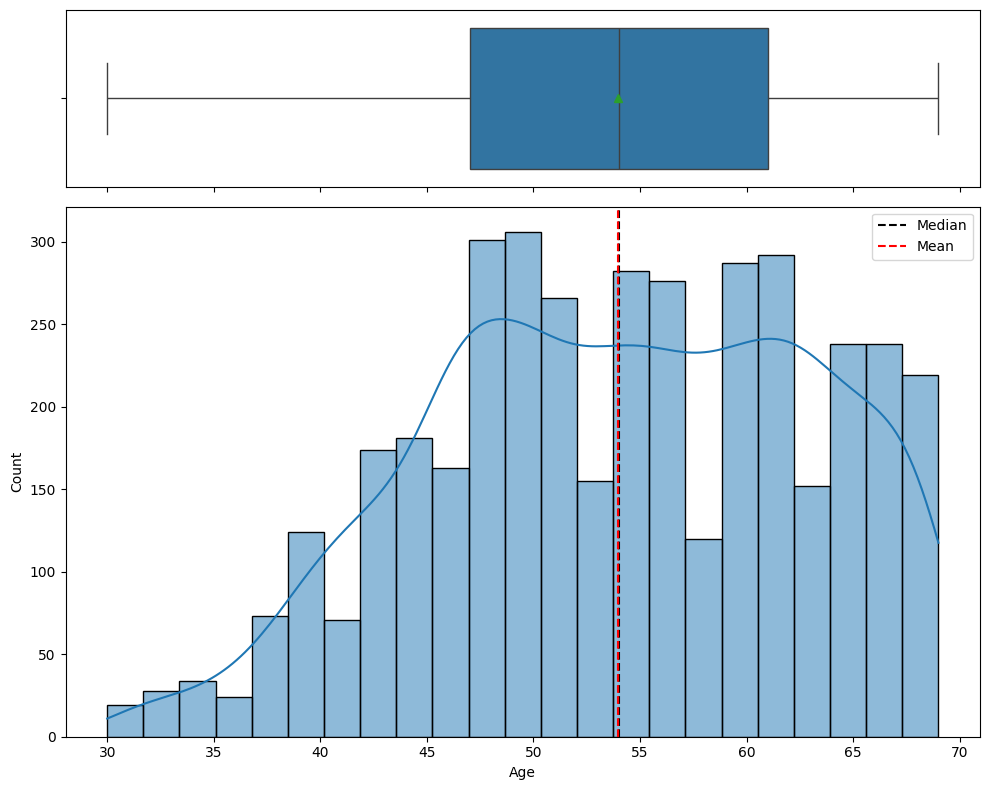

In [20]:
hist_boxplot('Age')

* Both median and mean age is close to 55.
* The majority of patients are between the age of 48 to 60, indicating age may be a significant risk factor for breast cancer.

**Tumor Size**

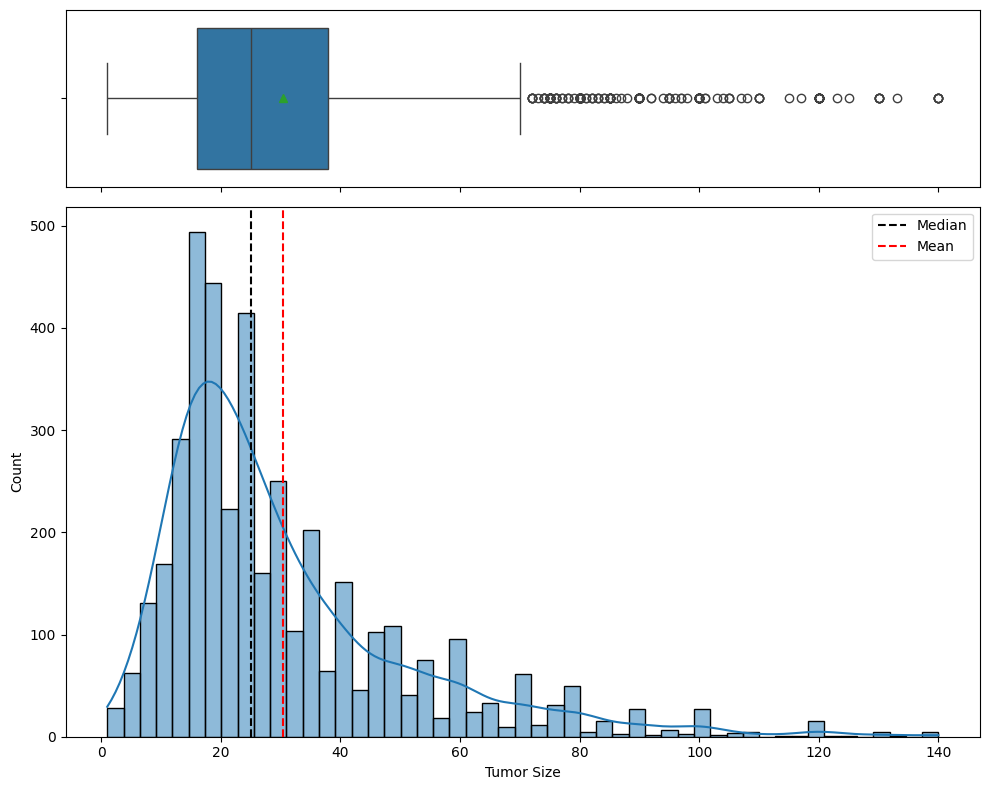

In [21]:
hist_boxplot('Tumor Size')

* There are some outliers for tumor size over 60, these patients are likely dead patients.
* The majority of patients have tumor size from 16 to 38, indicating size of the tumor for dead patients may be much bigger than alive patients.

**Regional Node Examined**

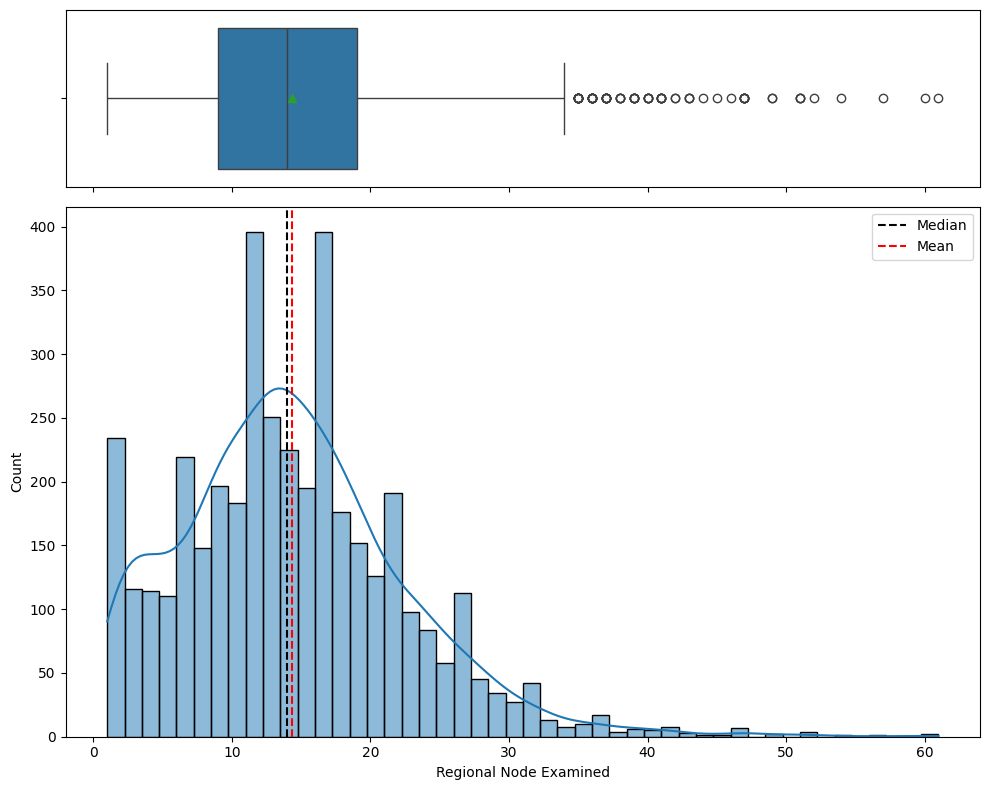

In [22]:
hist_boxplot('Regional Node Examined')

* The majority of patients have regional node examined from approximately 9 to 19, some patients have over 40 nodes examined.

* Since the 'Regional node examined' means the total number of lymph nodes surgically removed and examined regardless of whether they have cancer, the larger number of examined node does not directly imply that patient is dead.

**Regional Node Positive**

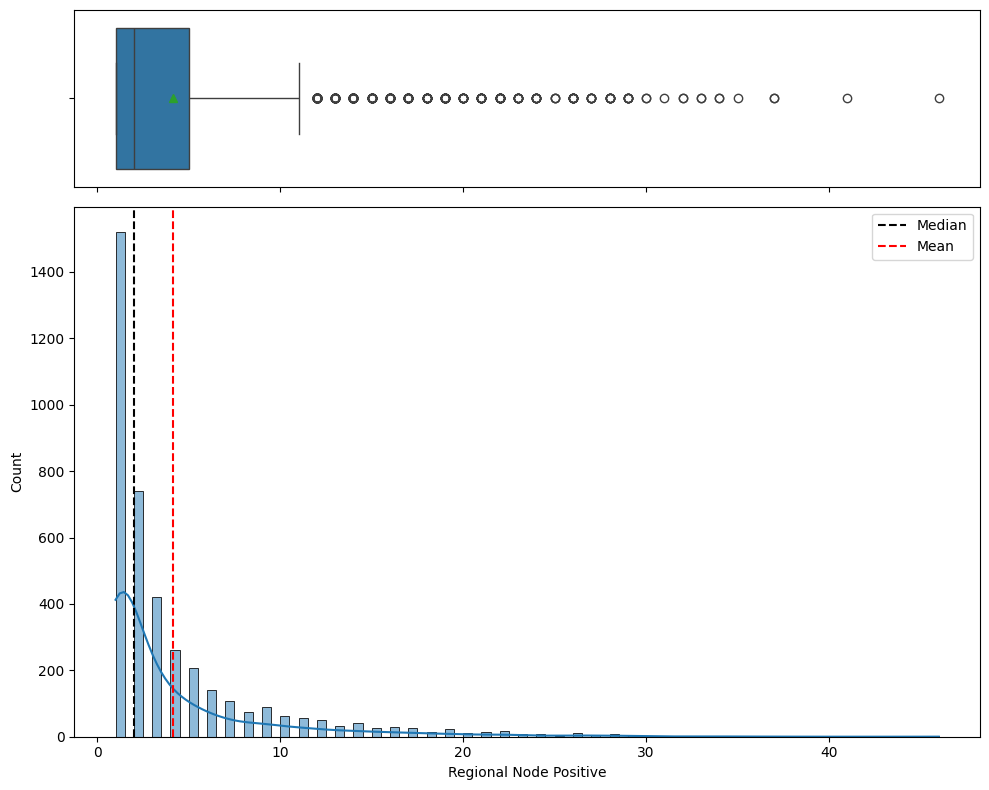

In [23]:
hist_boxplot('Regional Node Positive')

* The vast majority of the patients have relatively small number of positve regional nodes under 10 while there are patients with over 40 positive nodes, implying dead patients may have more positive nodes than others.

**Survival Months**

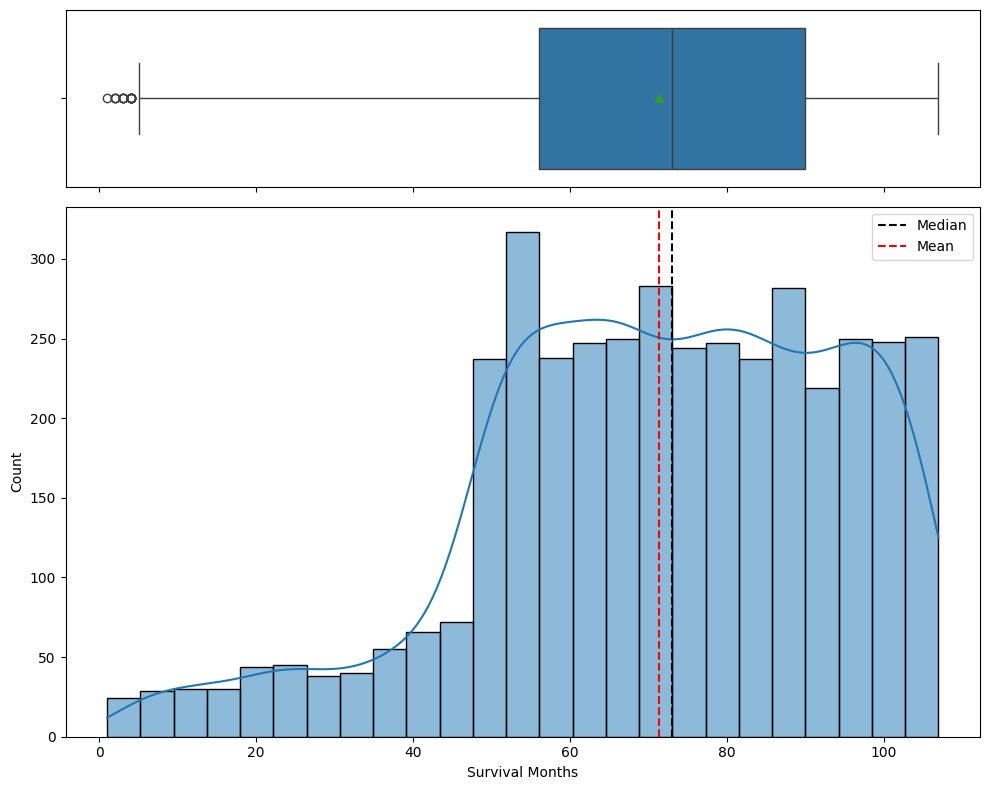

In [24]:
hist_boxplot('Survival Months')

* The majority of patients survive approximately 55 to 90 months.
* There is a steep increase after approximatley 50 months, indicating alive patients may generally live more than 50 months.

### b) Categorical Features

In [25]:
# Function to display a countplot with percentage labels for a categorical variable
def labeled_barplot(var):
    """
    Visualizes a labeled barplot with percentage for a given categorical variable.

    Parameters:
    - var: Column name of the categorical variable for visualization.

    Output:
    - A barplot with counts and percentage labels.
    """

    # Get the number of values in the variable and set the figure size
    count = df[var].nunique()
    plt.figure(figsize=(count + 3, 6))

    # Visualize the countplot
    ax = sns.countplot(data=df, x = var, order = df[var].value_counts().index[:],
                       palette = 'viridis', hue = var)

    # Total number of values in the feature to calculate percentages
    total = len(df[var])

    # Add percentage labels on top for each bar
    for p in ax.patches:
        # Calculate percentage of each category
        label = '{:.1f}%'.format(100 * p.get_height() / total)

        # Get the x and y coordinates for percentage label
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        # Annotate the plot with the percentage label
        ax.annotate(label, (x, y), ha = 'center', va = 'center',
                    xytext = (0, 6), size = 12, textcoords = 'offset points')

    # Show the final plot
    plt.show()

**Race**

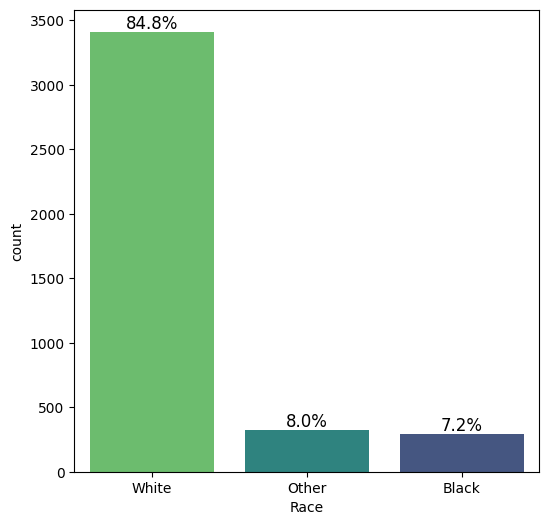

In [26]:
labeled_barplot('Race')

* Among the breast cancer patients (dead or alive), white population shows dominating figure, indicating white race may be more vulnerable than other races.

**Marital Status**

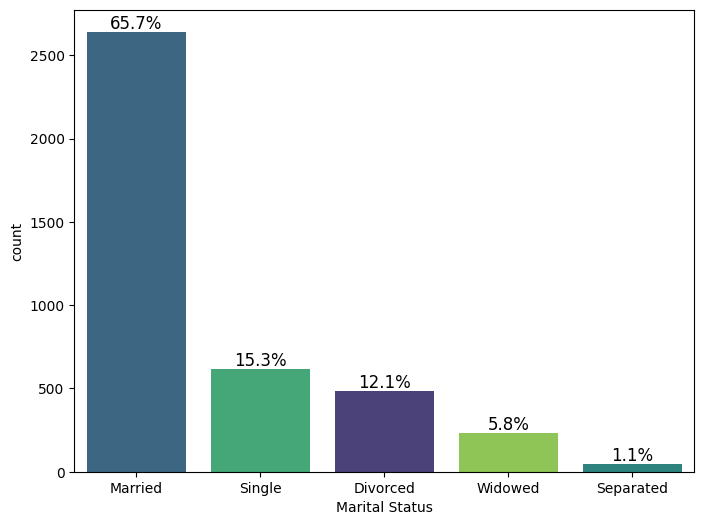

In [27]:
labeled_barplot('Marital Status')

* Among the breast cancer patients (dead or alive), married women seems to be dominating figure, implying breast cancer may have coorelation from the stress from the marriage.

**T Stage**

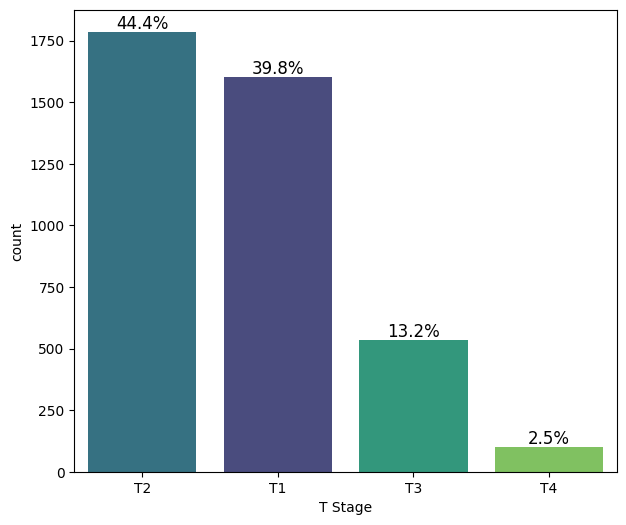

In [28]:
labeled_barplot('T Stage')

* The vast majority of T stages over 80 percent are in T1 and T2 stage.
* Very few patients are in the advanced T4 stage.

**N Stage**

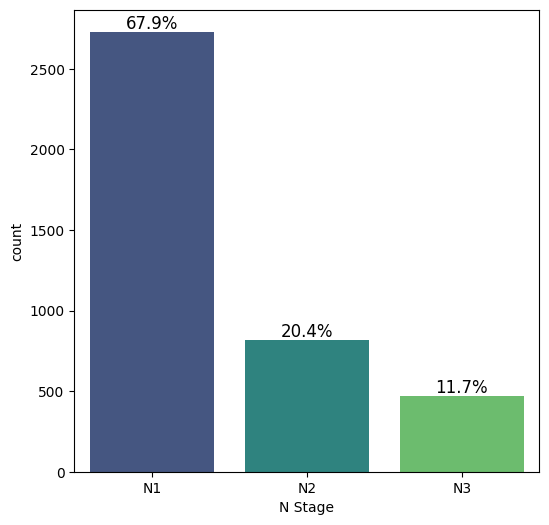

In [29]:
labeled_barplot('N Stage')

* N1 is most common, indicating limited node involvement.

**6th Stage**

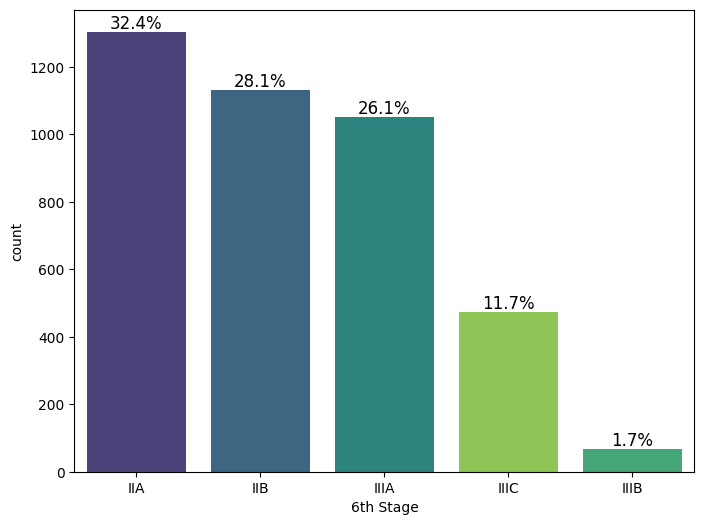

In [30]:
labeled_barplot('6th Stage')

* Most patients are in intermediate stage cancer such as Stage IIA, IIB, or IIIA.

**Grade**

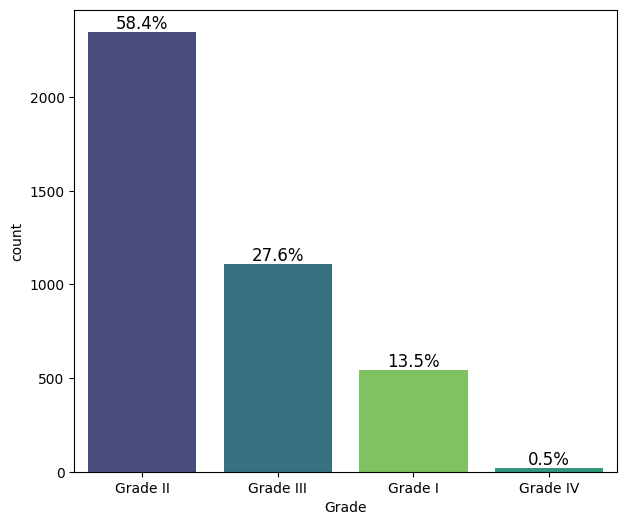

In [31]:
labeled_barplot('Grade')

* The majority of tumors are moderately differentiated (Grade II).
* Undifferentiated (Grade IV) is rare with 0.5 percent.

**A Stage**

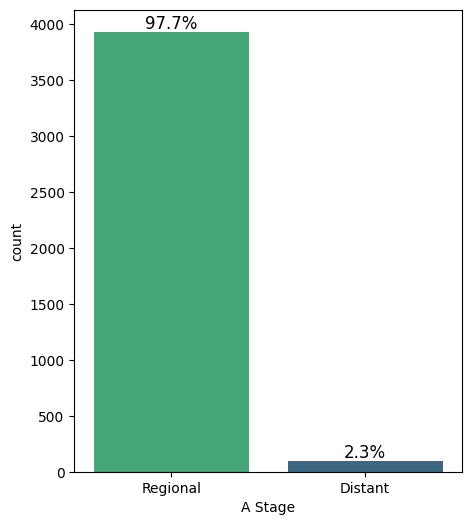

In [32]:
labeled_barplot('A Stage')

* The vast majority of 97.7 percent are regional cases, meaning the spread of cancer to nearby tissues.

**Estrogen Status**

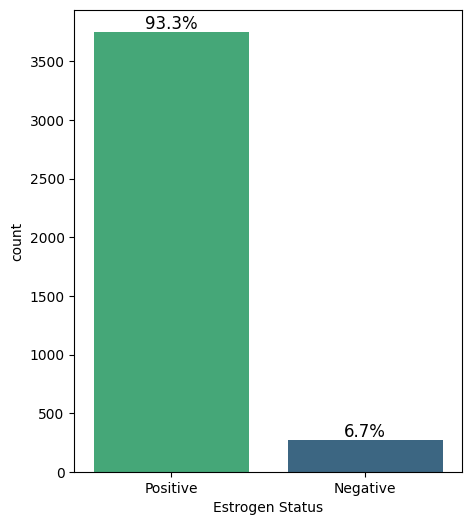

In [33]:
labeled_barplot('Estrogen Status')

* 93.3 percent of tumors are ER-positive, suggesting strong possibility for hormone therapy for patients.

**Progesterone Status**

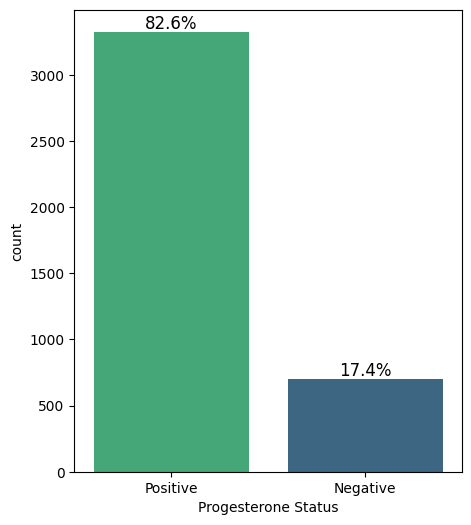

In [34]:
labeled_barplot('Progesterone Status')

* 82.7 percent are PR-positive, consistent with favorable hormonal therapy.

**Status**

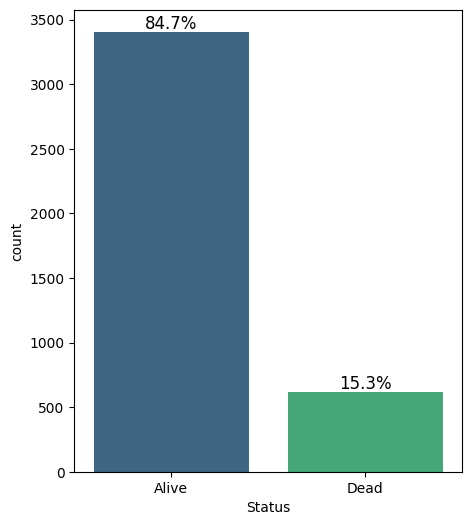

In [35]:
labeled_barplot('Status')

* The target variable of the dataset, showing the imbalanceness of the data.

### Bivariate Analysis

### a) Numeric features & Status

In [36]:
# Function to plot correlation between status and numeric variables
def distribution_plot(predictor, target):
  """
  Visualizes the distribution of a numeric variable (predictor) across different classes of the target variable.

  Parameters:
  - predictor: Name of the numeric predictor variable.
  - target: Name of the binary target variable (Status).

  Output:
  - Histogram for Alive group
  - Histogram for Dead group
  - Boxplot with outliers
  - Boxplot without outliers
  """
  # Create subplots with specified figure size
  fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))

  # Extract unique classes (alive / dead) from the target variable
  target_uniq = df[target].unique()

  # Histogram of predictor that counts alive patients
  axs[0, 0].set_title(f'Histogram Distribution of {target} (Alive)')
  sns.histplot(data = df[df[target] == target_uniq[0]], x = predictor, kde = True, ax = axs[0, 0], color = 'teal', stat = 'density')

  # Histogram of predictor that counts dead patients
  axs[0, 1].set_title(f'Histogram Distribution of {target} (Dead)')
  sns.histplot(data = df[df[target] == target_uniq[1]], x = predictor, kde = True, ax = axs[0, 1], color = 'orange', stat = 'density')

  # Boxplot of predictor and target with outliers
  axs[1, 0].set_title(f'Boxplot of {target} by {predictor}')
  sns.boxplot(data = df, x = target, y = predictor, ax = axs[1, 0], palette = 'pastel', hue = target, legend = False, showmeans = True)

  # Boxplot of predictor and target without outliers
  axs[1, 1].set_title(f'Boxplot of {target} by {predictor} without outliers')
  sns.boxplot(data = df, x = target, y = predictor, ax = axs[1, 1], palette = 'pastel', showfliers = False, hue = target, legend = False, showmeans = True)

  # Improve layout and display
  plt.tight_layout()
  plt.show()

**Age & Status**

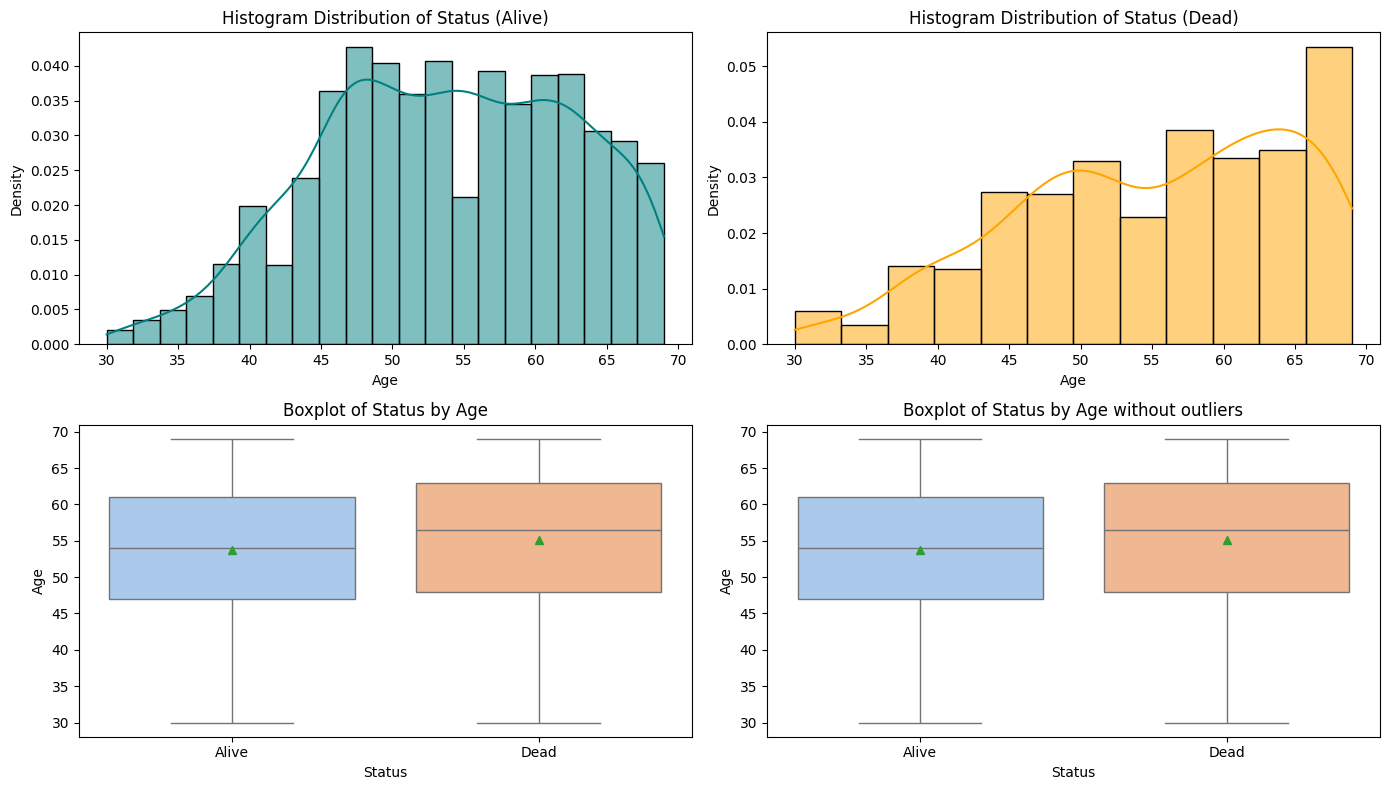

In [37]:
distribution_plot('Age', 'Status')

* Both groups show growth after age 40.
* Median and mean age are slightly higher in the dead group.
* No significant outliers.

**Tumor Size & Status**

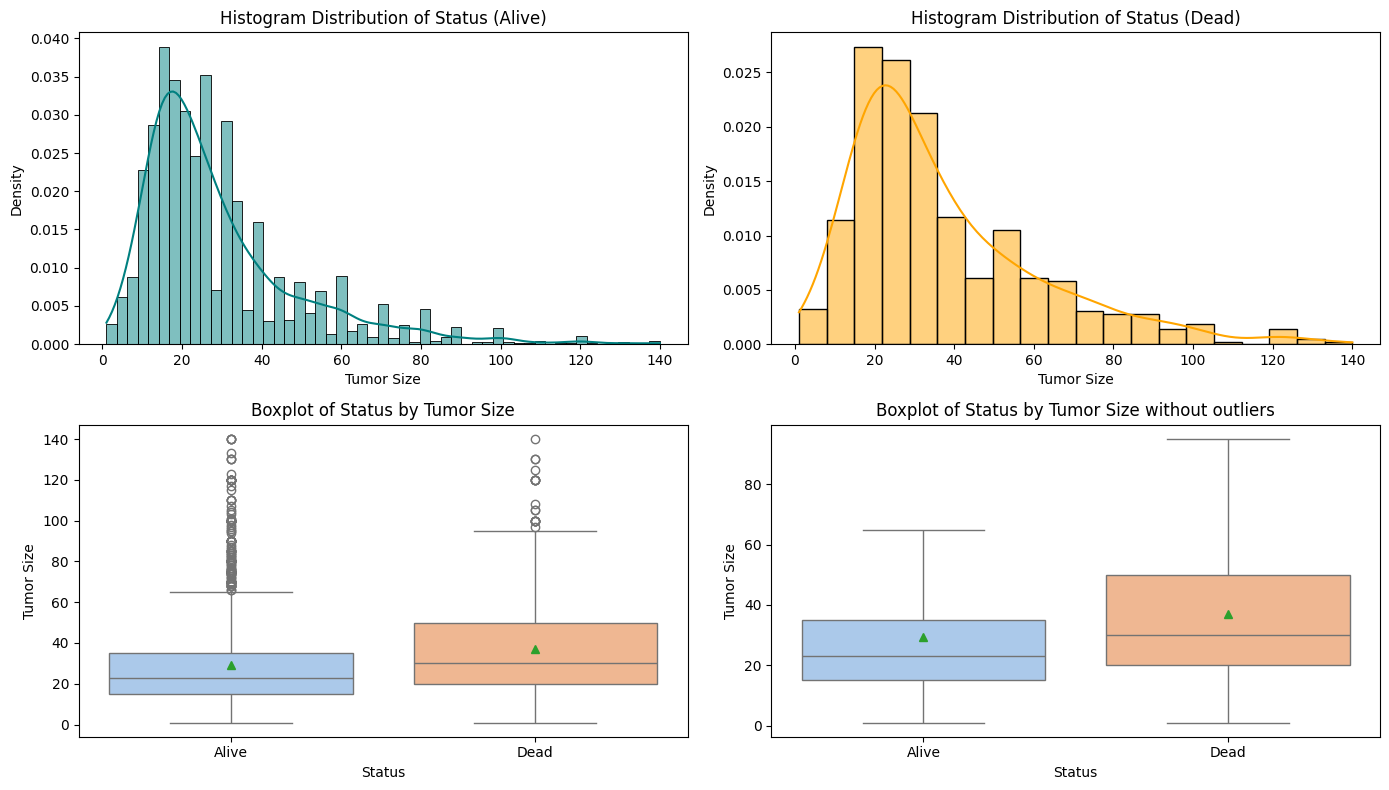

In [38]:
distribution_plot('Tumor Size', 'Status')

* Alive patients have smaller tumor sizes, peaking around 15–20 mm and dead patients tend to have larger tumors.

* Median and mean tumor size are both higher in the dead group, indicating larger tumor sizes overall.

* The Alive group has many outliers, but the majority of the values remain lower than the dead group.

**Regional Node Examined vs Status**

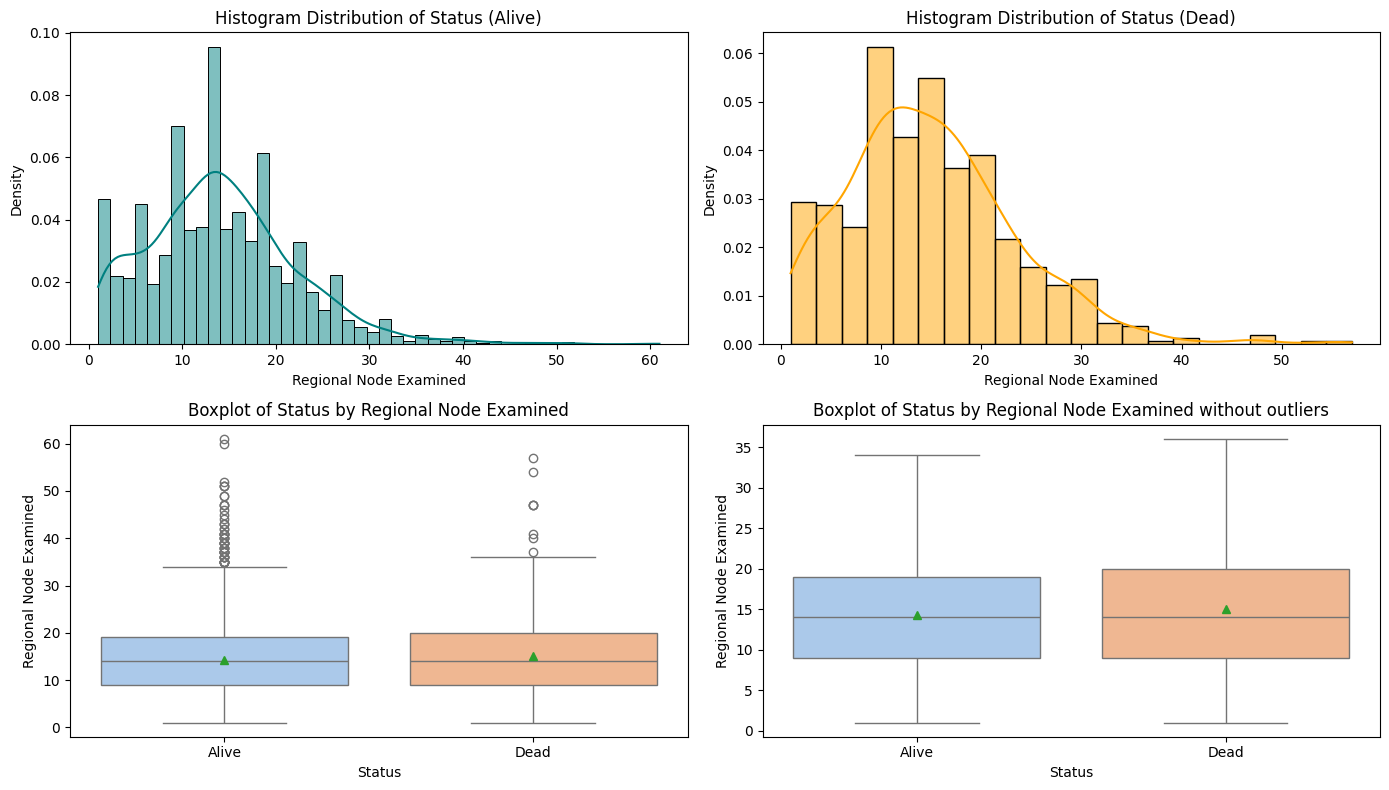

In [39]:
distribution_plot('Regional Node Examined', 'Status')

* Both groups are right-skewed, with majority of patients having 10–20 nodes examined.
* Dead patients slightly more often had more nodes examined.
* Distribution is similar, but the Alive group has more high outliers.

**Regional Node Positive & Status**

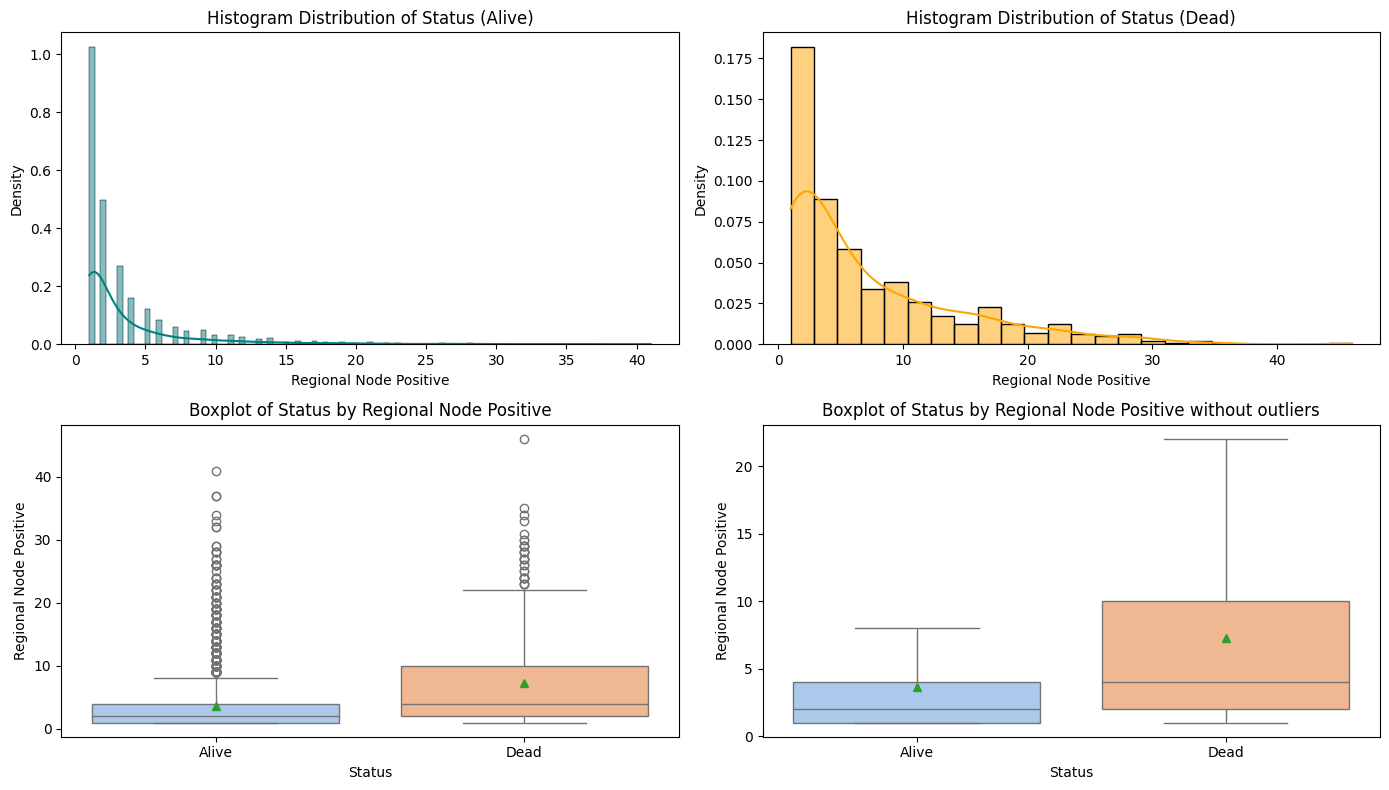

In [40]:
distribution_plot('Regional Node Positive', 'Status')

* Alive patients mostly have 5- positive nodes and dead patients show a wider spread, having more 5+ positive nodes.

* Median, mean, and upper range are all higher in the dead group.

**Survival Months vs Status**

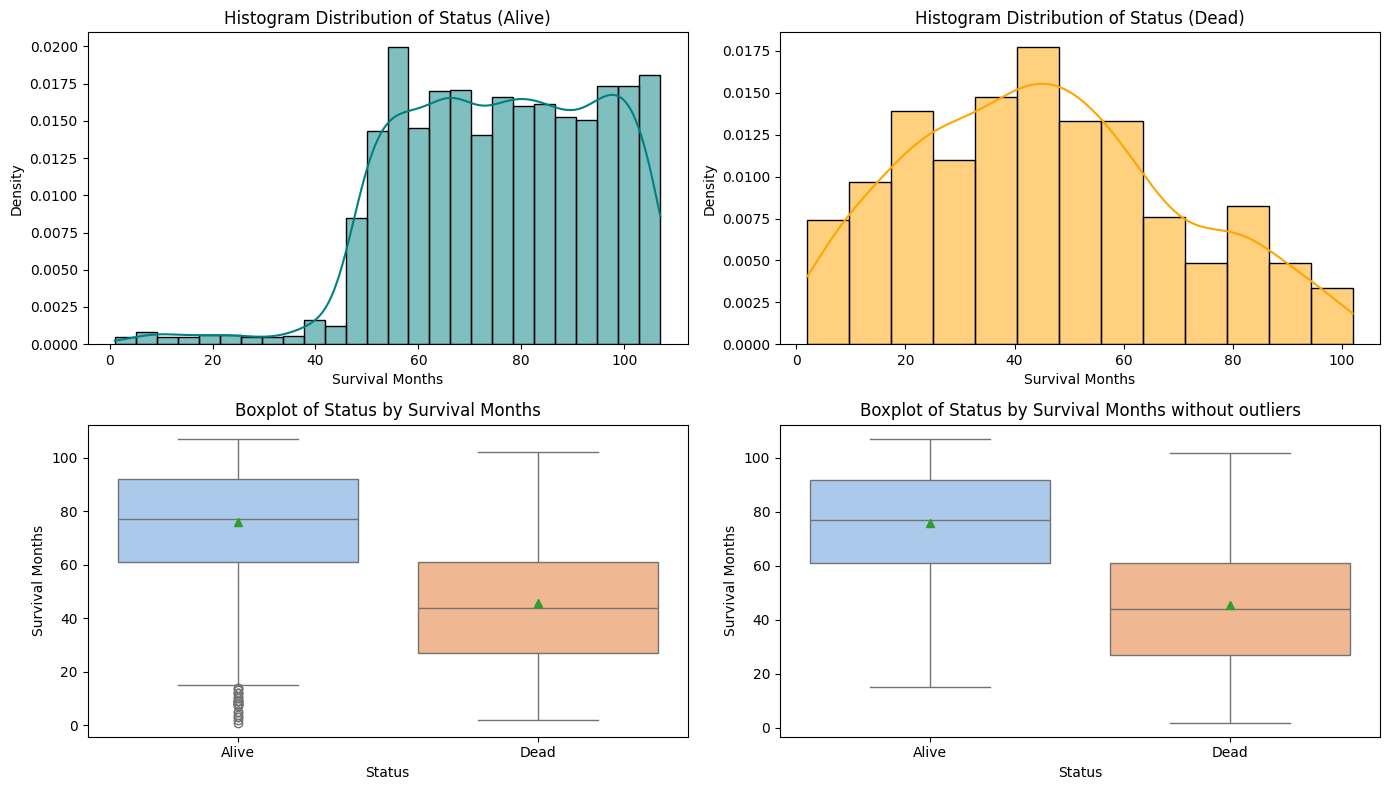

In [41]:
distribution_plot('Survival Months', 'Status')

* Alive patients have consistently high survival durations, mostly 60+ months, with a sharp rise after 40 months.

* Dead patients peak around 40–60 months and decline, showing shorter overall survival.

* Alive group has higher median and mean survival.

### b) Categorical features & Status

In [42]:
# Function to plot the correlation status and categorical variables
def stacked_barplot(predictor, target):
    """
    Plots a stacked bar chart showing the distribution of a categorical predictor
    variable across the target variable.

    Parameters:
    - predictor: Name of the categorical predictor variable.
    - target: Name of the binary target variable (Status).

    Output:
    - Frequency table of predictor vs. target
    - Normalized stacked bar plot
    """
    # Number of unique categories in the predictor
    count = df[predictor].nunique()

    # Identify the minority class to sort the plot accordingly
    sorter = df[target].value_counts().index[-1]

    # Print frequency table
    freq_table = pd.crosstab(df[predictor], df[target], margins = True).sort_values(by = sorter, ascending = False)
    print(freq_table, '\n')

    # Normalized table for plotting
    normalized_table = pd.crosstab(df[predictor], df[target], normalize = 'index').sort_values(by = sorter, ascending = False)

    # Set up figure size dynamically
    plt.figure(figsize = (count + 4, 5))

    # Generate the stacked barplot
    ax = normalized_table.plot(kind = 'bar', stacked = True)

    # Display djustments
    plt.title(f"Distribution of {target} by {predictor}")
    plt.xlabel(predictor)
    plt.ylabel("Proportion")
    plt.xticks(rotation = 0)
    plt.legend(title = target, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.subplots_adjust(right = 0.8)

    # Improve layout and display
    plt.tight_layout()
    plt.show()

**Race & Status**

Status  Alive  Dead   All
Race                     
All      3407   616  4023
White    2902   510  3412
Black     218    73   291
Other     287    33   320 



<Figure size 700x500 with 0 Axes>

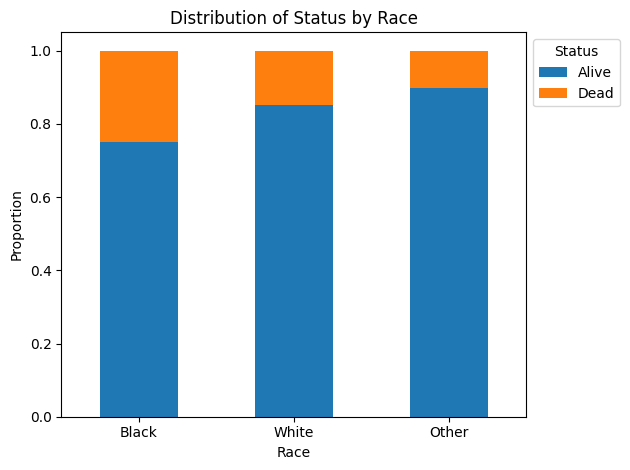

In [43]:
stacked_barplot('Race', 'Status')

* All groups show majority of patients are alive.
* Black patients have a higher proportion of deaths compared to other groups.

**Marital Status & Status**

Status          Alive  Dead   All
Marital Status                   
All              3407   616  4023
Married          2284   358  2642
Single            511   104   615
Divorced          396    90   486
Widowed           186    49   235
Separated          30    15    45 



<Figure size 900x500 with 0 Axes>

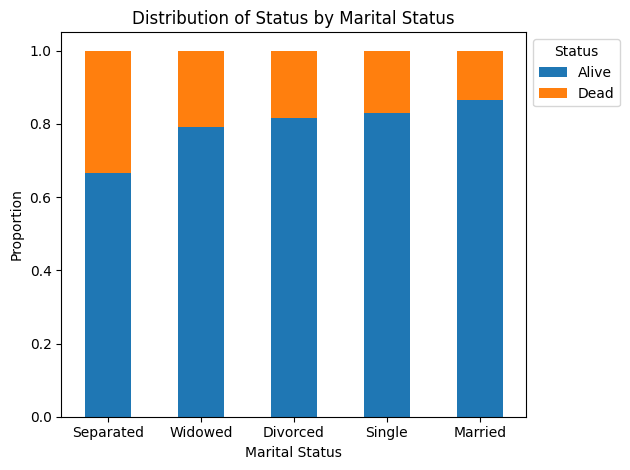

In [44]:
stacked_barplot('Marital Status', 'Status')

* Married patients show the highest survival proportion.

* Separated and widowed individuals have notably higher death rates, suggesting lack of social/family support may impact survival.

**T Stage & Status**

Status   Alive  Dead   All
T Stage                   
All       3407   616  4023
T2        1483   303  1786
T1        1445   157  1602
T3         417   116   533
T4          62    40   102 



<Figure size 800x500 with 0 Axes>

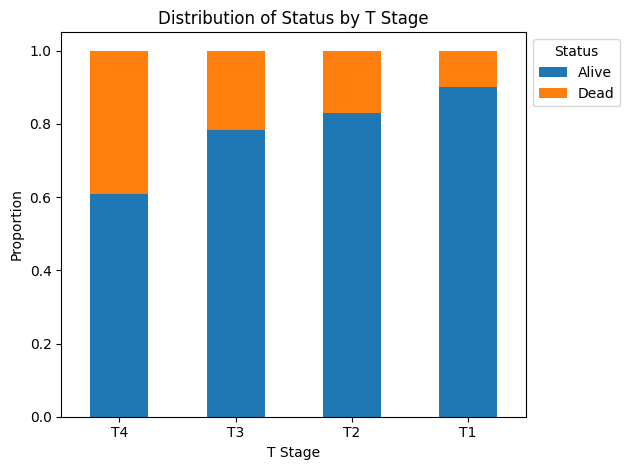

In [45]:
stacked_barplot('T Stage', 'Status')

* T4 stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher T stages, suggesting strong correlation between T Stage and Status.

**N Stage & Status**

Status   Alive  Dead   All
N Stage                   
All       3407   616  4023
N1        2461   270  2731
N3         291   181   472
N2         655   165   820 



<Figure size 700x500 with 0 Axes>

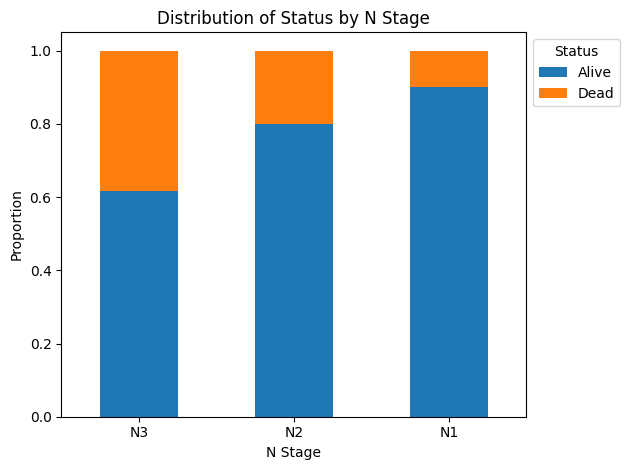

In [46]:
stacked_barplot('N Stage', 'Status')

* N3 stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher N stages, suggesting strong correlation between N Stage and Status.

**6th Stage & Status**

Status     Alive  Dead   All
6th Stage                   
All         3407   616  4023
IIIA         866   184  1050
IIIC         291   181   472
IIB          995   135  1130
IIA         1208    96  1304
IIIB          47    20    67 



<Figure size 900x500 with 0 Axes>

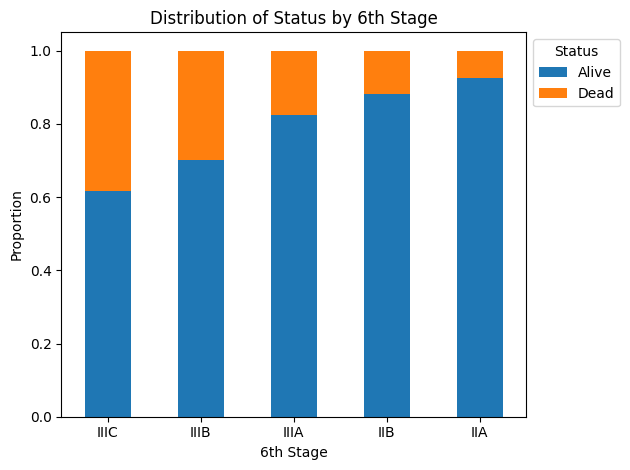

In [47]:
stacked_barplot('6th Stage', 'Status')

* IIIC stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher 6th stages, suggesting strong correlation between 6th Stage and Status.

**Grade & Status**

Status     Alive  Dead   All
Grade                       
All         3407   616  4023
Grade II    2045   305  2350
Grade III    848   263  1111
Grade I      504    39   543
Grade IV      10     9    19 



<Figure size 800x500 with 0 Axes>

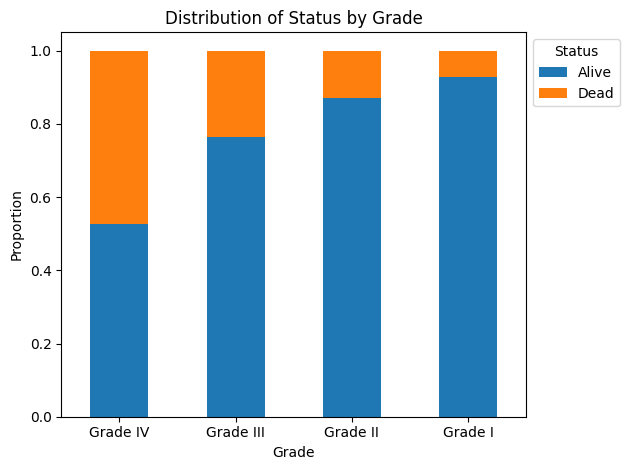

In [48]:
stacked_barplot('Grade', 'Status')

* Grade IV (Undifferentiated) shows approximatley 50 percent of death rate.
* Mortality rate increases with higher Grade level, suggesting strong correlation between Grade and Status.

**A Stage & Status**

Status    Alive  Dead   All
A Stage                    
All        3407   616  4023
Regional   3350   581  3931
Distant      57    35    92 



<Figure size 600x500 with 0 Axes>

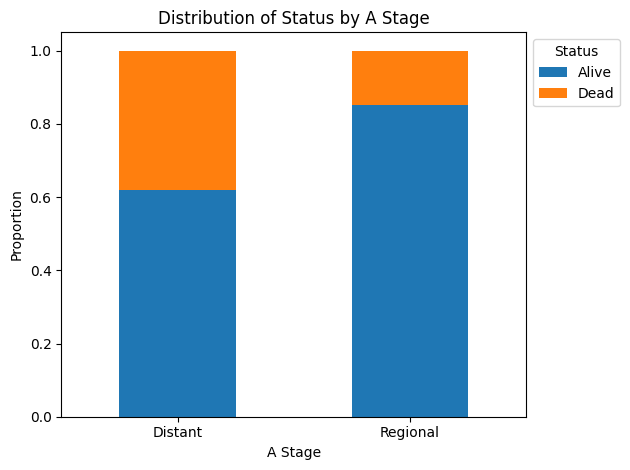

In [49]:
stacked_barplot('A Stage', 'Status')

* Patients with distant stage shows much higher death rate than regional stage.

**Estrogen Status & Status**

Status           Alive  Dead   All
Estrogen Status                   
All               3407   616  4023
Positive          3246   508  3754
Negative           161   108   269 



<Figure size 600x500 with 0 Axes>

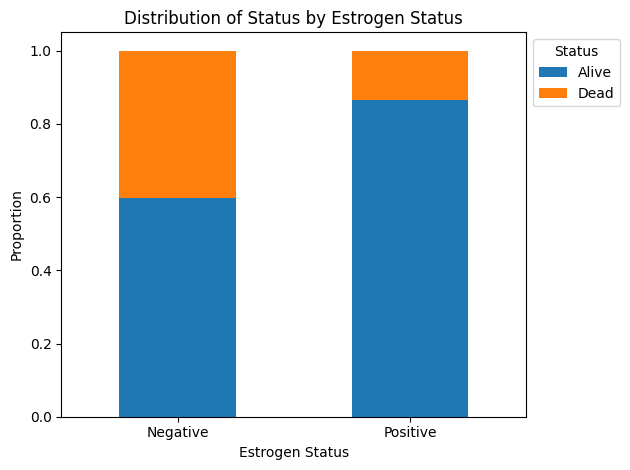

In [50]:
stacked_barplot('Estrogen Status', 'Status')

* Patients with ER-negative tumors have a much higher mortality rate.

**Progesterone Status & Stats**

Status               Alive  Dead   All
Progesterone Status                   
All                   3407   616  4023
Positive              2913   412  3325
Negative               494   204   698 



<Figure size 600x500 with 0 Axes>

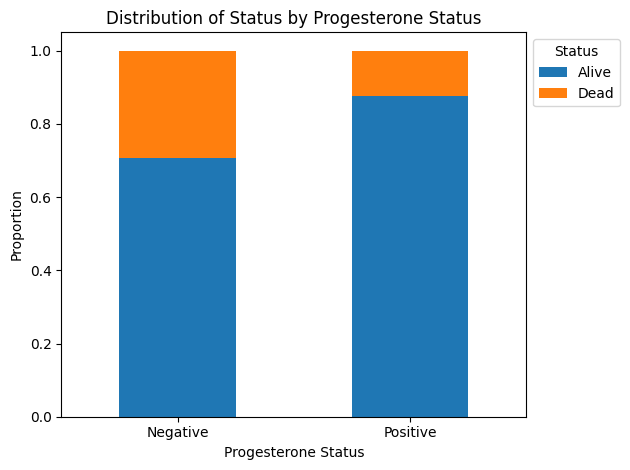

In [51]:
stacked_barplot('Progesterone Status', 'Status')

* PR-negative patients have a significantly higher death rate.

## Hypothesis Testing

* Hypothesis testing will help discover whether observed differences in features between alive vs dead groups are statistically significant.

In [52]:
# Convert the categorical target variable Status to binary (1 = Aive / 0 = Dead) numeric feature
df['Status'] = df['Status'].apply(lambda x: 1 if x == 'Alive' else 0).astype(int)
df.Status.value_counts(1)

,proportion
Status,
1,0.84688
0,0.15312


* The target variable is highly imbalanced with approximately 85:15 (Alive / Dead)

In [53]:
# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include = 'category').columns.tolist()
num_cols = df.select_dtypes(include = np.number).columns.drop('Status').tolist()

### **Base Hypothesis for Statistical Testing**

To understand whether specific features differ significantly between patients who are alive and dead, we define the following hypotheses:

* **Null Hypothesis (H₀):** There is no significant difference in the selected features between two groups of patients (Alive / Dead).
* **Alternative Hypothesis (H₁):** There is a significant difference in the selected features between two groups of patients (Alive / Dead).

### **Choice of Tests**

Since we will using various machine learning and deep learning models that do not rely on traditional statistical assumptions (such as normality or homoscedasticity), our choice of tests will be non-parametric tests, which do not require strong distributional assumptions:

* **Mann–Whitney U Test**: Applied to numeric variables to assess whether the distribution of values differs between the two outcome groups (Alive vs. Dead).

* **Chi-square Test of Independence**: Applied to categorical variables to determine whether there is a significant association between the variable and patient status.

These tests may provide statistically robust insights beyond the visualizations.

### Mann–Whitney U Test

In [54]:
def mannwhitney_test(df, predictor, target, group1_val, group2_val):
    """
    Perform Mann–Whitney U test on a numeric column between two groups.

    Parameters:
    - df: DataFrame containing the data
    - predictor: the name of the numeric column to compare
    - target: the column defining the two groups of patient status
    - group1_val: value representing the first group in target (alive)
    - group2_val: value representing the second group in target (dead)

    Output:
    - U statistics and p-values for numeric features
    """
    group1 = df[df[target] == group1_val][predictor]
    group2 = df[df[target] == group2_val][predictor]

    u_stat, p_val = mannwhitneyu(group1, group2, alternative = 'two-sided')
    print(f"Mann–Whitney U Test for {predictor}: U = {u_stat:.2f}, p-value = {p_val:.5f}")

In [55]:
for col in num_cols:
    mannwhitney_test(df, predictor = col, target = 'Status', group1_val = 1, group2_val = 0)
    print('-' * 70)

Mann–Whitney U Test for Age: U = 944053.00, p-value = 0.00007
----------------------------------------------------------------------
Mann–Whitney U Test for Tumor Size: U = 813139.50, p-value = 0.00000
----------------------------------------------------------------------
Mann–Whitney U Test for Regional Node Examined: U = 1001005.00, p-value = 0.06814
----------------------------------------------------------------------
Mann–Whitney U Test for Regional Node Positive: U = 692492.00, p-value = 0.00000
----------------------------------------------------------------------
Mann–Whitney U Test for Survival Months: U = 1748295.00, p-value = 0.00000
----------------------------------------------------------------------


* According to the Mann-Whitney U Test, Regional Node Examined does not show a statistically significant difference (p > 0.05), and thus we fail to reject the null hypothesis for this variable.

* These results suggest that factors such as age, tumor burden, and node involvement are potentially important in influencing survival outcomes, whereas the number of regional nodes examined alone may not be a discriminative factor.

### Chi-Squared Test

In [56]:
def chi_squared_test(df, predictor, target):
    """
    Performs the Chi-Squared Test of Independence between a categorical feature and the target.

    Parameters:
    - df: DataFrame containing the data
    - predictor: Name of the categorical feature column
    - target: Name of the binary target column (Status)

    Output:
    - Test statistic and p-values of categorical columns
    """
    contingency = pd.crosstab(df[predictor], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-Square Test for {predictor}: Chi² = {chi2:.2f}, p-value = {p:.5f}")

In [57]:
for col in cat_cols:
    chi_squared_test(df, predictor = col, target = 'Status')
    print('-' * 70)

Chi-Square Test for Race: Chi² = 27.96, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Marital Status: Chi² = 28.22, p-value = 0.00001
----------------------------------------------------------------------
Chi-Square Test for T Stage: Chi² = 103.35, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for N Stage: Chi² = 269.77, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for 6th Stage: Chi² = 281.45, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Grade: Chi² = 112.48, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for A Stage: Chi² = 35.75, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Estrogen Status: Chi² = 135.09, p-value = 0.0000

* According to Chi-Square Test, it shows a statistically significant difference (p > 0.05) for all the categorical variables, therefore, rejecting the null hypothesis.

* These results suggest that categorical features are potentially important in influencing survival outcomes.

* It seems that there is no valid reason to drop features according to the statistical tests.

## Data Preprocessing

In [58]:
# Separate ordinal and nominal categorical features
ordinal_cat = ['T Stage', 'N Stage', '6th Stage', 'Grade']
nominal_cat = [col for col in cat_cols if col not in ordinal_cat]

In [62]:
# Divide the target and predictor
X_raw = df.drop('Status', axis=1)
y = df['Status']

# Create train/validation/test splits
X_temp_raw, X_test_raw, y_temp, y_test = train_test_split(
    X_raw, y, test_size = 0.2, random_state = 1, stratify = y
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp_raw, y_temp, test_size = 0.25, random_state = 1, stratify = y_temp
)

# Print the splitted number of rows
print(f"Splits - Train: {X_train_raw.shape[0]}, Validation: {X_val_raw.shape[0]}, Test: {X_test_raw.shape[0]}")

Splits - Train: 2413, Validation: 805, Test: 805


In [63]:
# Set custom order for ordinal categorical variables
custom_order = [
    ['T1', 'T2', 'T3', 'T4'],  # T Stage
    ['N1', 'N2', 'N3'],        # N Stage
    ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC'],  # 6th Stage
    ['Grade I', 'Grade II', 'Grade III','Grade IV']  # Grade
]

In [64]:
# Initialize encoders
ordinal_encoder = OrdinalEncoder(categories = custom_order)
onehot_encoder = OneHotEncoder(sparse_output = False, drop = None)

# fit encoders on training data only
ordinal_encoder.fit(X_train_raw[ordinal_cat])
onehot_encoder.fit(X_train_raw[nominal_cat])

OneHotEncoder(sparse_output=False)

* Since there are ordinal categorical variables, we set the custom order to have accurate results.

* Fit the encoders to training data only to avoid data leakage and have accurate results.

In [66]:
# Transform the ordinal categorical variables on the training data
X_train_ord = pd.DataFrame(
    ordinal_encoder.transform(X_train_raw[ordinal_cat]).astype(int),
    columns = ordinal_cat,
    index = X_train_raw.index
)

# Transform the nominal categorical variables on the training data
X_train_nom = pd.DataFrame(
    onehot_encoder.transform(X_train_raw[nominal_cat]).astype(int),
    columns = onehot_encoder.get_feature_names_out(nominal_cat),
    index=X_train_raw.index
)

In [67]:
# Transform the ordinal categorical variables on the validation data
X_val_ord = pd.DataFrame(
    ordinal_encoder.transform(X_val_raw[ordinal_cat]).astype(int),
    columns = ordinal_cat,
    index = X_val_raw.index
)

# Transform the nominal categorical variables on the validation data
X_val_nom = pd.DataFrame(
    onehot_encoder.transform(X_val_raw[nominal_cat]).astype(int),
    columns = onehot_encoder.get_feature_names_out(nominal_cat),
    index = X_val_raw.index
)

In [68]:
# Transform the ordinal categorical variables on the test data
X_test_ord = pd.DataFrame(
    ordinal_encoder.transform(X_test_raw[ordinal_cat]).astype(int),
    columns = ordinal_cat,
    index = X_test_raw.index
)

# Transform the nominal categorical variables on the test data
X_test_nom = pd.DataFrame(
    onehot_encoder.transform(X_test_raw[nominal_cat]).astype(int),
    columns = onehot_encoder.get_feature_names_out(nominal_cat),
    index = X_test_raw.index
)

In [69]:
# Combine encoded features with numerical features
X_train = pd.concat([X_train_ord, X_train_nom, X_train_raw[num_cols]], axis = 1)
X_val = pd.concat([X_val_ord, X_val_nom, X_val_raw[num_cols]], axis = 1)
X_test = pd.concat([X_test_ord, X_test_nom, X_test_raw[num_cols]], axis = 1)

# Print the splitted number of rows
print(f"Processed splits - Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")

Processed splits - Train: 2413, Validation: 805, Test: 805


In [70]:
# scale numerical features (fit on training, transform on all)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

* Now our data preprocessing is completed (encoding - scaling pipeline).

## Quick Model Evaulation

In [71]:
y_train.value_counts(1)

,proportion
Status,
1,0.846664
0,0.153336


* As the dataset is imbalanced (1 = Alive / 0 = Dead), we will set the class weights for different groups of machine learning techniques for quick model evaluation.

* In the pipeline we could have used oversampling techniques such as SMOTE, but manullay setting the class and sample weight showed better results in F1 score overall.

In [72]:
# Define the class_weight parameter as 'balanced' for handling class imbalance
class_weight = 'balanced'

# Set up StratifiedKFold cross-validation (5 splits)
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

### Group 1

In [73]:
# List of models to evaluate
models_group1 = [
    ('Logistic Regression', LogisticRegression(random_state = 1, class_weight = class_weight)),
    ('SVM', SVC(random_state = 1, class_weight = class_weight)),
    ('Random Forest', RandomForestClassifier(random_state = 1, class_weight = class_weight)),
    ('Extra Trees', ExtraTreesClassifier(random_state = 1, class_weight = class_weight)),
    ('Decision Tree', DecisionTreeClassifier(random_state = 1, class_weight = class_weight)),
]

# Print header for model performance comparison
print("\nGROUP 1: Model Performance Comparisons\n")

# Loop through each model in the models_group1 list
for name, model in models_group1:
    # Perform cross-validation using F1 score as the evaluation metric
    scores1 = cross_val_score(model, X_train, y_train, cv = kfold, scoring = make_scorer(f1_score))

    # Print the average F1 score from the cross-validation
    print(f"{name} CV F1: {scores1.mean():.4f}")

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    val_pred = model.predict(X_val)

    # Print the F1 score for the model's performance on the validation set
    print(f"{name} Validation F1: {f1_score(y_val, val_pred):.4f}\n")


GROUP 1: Model Performance Comparisons

Logistic Regression CV F1: 0.8643
Logistic Regression Validation F1: 0.8774

SVM CV F1: 0.9022
SVM Validation F1: 0.9008

Random Forest CV F1: 0.9445
Random Forest Validation F1: 0.9448

Extra Trees CV F1: 0.9357
Extra Trees Validation F1: 0.9339

Decision Tree CV F1: 0.9032
Decision Tree Validation F1: 0.9004



### Group 2

In [74]:
# Define the base classifiers for Bagging and AdaBoost
bag_base = DecisionTreeClassifier(class_weight=class_weight)  # Base classifier for Bagging
ada_base = DecisionTreeClassifier(class_weight=class_weight)  # Base classifier for AdaBoost

# List of models to evaluate
models_group2 = [
    ("Bagging", BaggingClassifier(estimator = bag_base, random_state = 1)),  # Bagging model
    ("AdaBoost", AdaBoostClassifier(estimator = ada_base, random_state = 1))  # AdaBoost model
]

# Print a header for the model performance comparison
print("\nGROUP 2: Model Performance Comparisons\n")

# Loop through each model in the models_group2
for name, model in models_group2:

    # Perform cross-validation using the F1 score as the evaluation metric
    scores2 = cross_val_score(model, X_train, y_train, cv = kfold, scoring = make_scorer(f1_score))

    # Print the average F1 score from cross-validation
    print(f"{name} CV F1: {scores2.mean():.4f}")

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    val_pred2 = model.predict(X_val)

    # Print the F1 score for the model's performance on the validation set
    print(f"{name} Validation F1: {f1_score(y_val, val_pred2):.4f}\n")


GROUP 2: Model Performance Comparisons

Bagging CV F1: 0.9391
Bagging Validation F1: 0.9308

AdaBoost CV F1: 0.9048
AdaBoost Validation F1: 0.8932



### Group 3

In [75]:
# Calculate the scale_pos_weight for XGBoost to handle class imbalance
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# List of models to evaluate
models_group3 = [
    ("HistGradient", HistGradientBoostingClassifier(class_weight = 'balanced', random_state = 1)),  # HistGradientBoosting with balanced class weights
    ("XGBoost", XGBClassifier(random_state = 1, eval_metric = "logloss", scale_pos_weight = scale_pos))  # XGBoost with scale_pos_weight to handle imbalance
]

# Print a header for model performance comparison
print("\nGROUP 3: Model Performance Comparisons\n")

# Loop through each model in the models_group3
for name, model in models_group3:

    # Perform cross-validation using the F1 score as the evaluation metric
    scores3 = cross_val_score(model, X_train, y_train, cv = kfold, scoring = make_scorer(f1_score))

    # Print the average F1 score from cross-validation
    print(f"{name} CV F1: {scores3.mean():.4f}")

    # Train the model on the full training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    val_pred3 = model.predict(X_val)

    # Print the F1 score on the validation set to evaluate the model performance
    print(f"{name} Validation F1: {f1_score(y_val, val_pred3):.4f}\n")



GROUP 3: Model Performance Comparisons

HistGradient CV F1: 0.9297
HistGradient Validation F1: 0.9233

XGBoost CV F1: 0.9226
XGBoost Validation F1: 0.9156



* From the three groups, we select Random Forest, Bagging, HistGradient Boosting, and XGBoost for hyper - parameter tuning based on the validation performance.

## Model Training - Hyper Parameter Tuning

In [76]:
# Function to check the general model performance
def model_performance_checker(model, predictors, target):
  """
  Calculates the model performance metrics based on the predictors and target.

  Parameters:
  - predictors: predictors.
  - target: target.

  Output:
  - Model performance metric containing accuracy, precision, recall, and f1 score.
  """

  # Model prediction on the predictors
  pred = model.predict(predictors)

  # Calculate score on the evaluation metrices
  acc = round(accuracy_score(target, pred), 3)
  precision = round(precision_score(target, pred), 3)
  recall = round(recall_score(target, pred), 3)
  f1 = round(f1_score(target, pred), 3)

  # Create dataframe on the metrices
  perf_df = pd.DataFrame({
      'Accuracy': acc,
      'Precision': precision,
      'Recall': recall,
      'F1': f1
  }, index = [0])

  # Return the dataframe
  return perf_df

### Machine Learning Models

### Random Forest Classifier

In [77]:
# Set scoring standard as F1 score as it shows balance between precision and recall
scorer = make_scorer(f1_score)

In [78]:
# Hyper-parameter Tuning
%%time

# Defining model
rf_clf = RandomForestClassifier(random_state = 1, class_weight = class_weight)

# Parameter grid to pass in RandomizedSearchCV
rf_param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": list(np.arange(1, 10, 1)),
    "min_samples_leaf": np.arange(1, 4),
    "min_samples_split": [3, 5, 7],
    'max_samples': [0.6, 0.8, 0.9, 1.0],
    'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Calling RandomizedSearchCV
rf_randomized_cv = RandomizedSearchCV(
    estimator = rf_clf,
    param_distributions = rf_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
rf_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(rf_randomized_cv.best_params_, rf_randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': np.int64(1), 'max_samples': 0.6, 'max_features': 0.8, 'max_depth': np.int64(9)} with CV score = 0.9428
CPU times: user 3.09 s, sys: 227 ms, total: 3.31 s
Wall time: 1min 54s


In [79]:
# Tune and fit the model
rf_tuned = RandomForestClassifier(class_weight = class_weight, random_state = 1, n_estimators = 200, min_samples_split = 3,
                                  min_samples_leaf = 1, max_samples = 0.6, max_features = 0.8, max_depth = 9)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=0.8,
                       max_samples=0.6, min_samples_split=3, n_estimators=200,
                       random_state=1)

In [80]:
# Model performance on training data
model_performance_checker(rf_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.95,0.955,0.987,0.971


In [81]:
# Model performance on validation data
rf_default = model_performance_checker(rf_tuned, X_val, y_val)
rf_default

,Accuracy,Precision,Recall,F1
0,0.894,0.917,0.962,0.939


* While there are slight differences between the metrices, especially in accuracy, but it is not huge.
* The result shows great result with all the metrics.
* However, we could try to improve this result by adjusting threshold on precision-recall.

#### Adjusting Precision-Recall Threshold

In [82]:
def precision_recall_by_threshold(model, X_val, y_val):
    """
    Get precision, recall, and F1 at thresholds from 0.1 to 0.9.

    Parameters:
    - model: Trained classifier
    - X_val: Validation features
    - y_val: True labels of the validation set

    Output:
    - DataFrame with precision, recall, and F1 at each threshold
    """
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_val)[:, 1]

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

    # Exclude last precision and recall to match thresholds length (0.1 ~ 0.9)
    precision = precision[:-1]
    recall = recall[:-1]

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Create DataFrame
    df = pd.DataFrame({
        'Threshold': np.round(thresholds, 3),
        'Precision': np.round(precision, 3),
        'Recall': np.round(recall, 3),
        'F1': np.round(f1, 3)
    })

    # Filter for thresholds between 0.1 and 0.9
    df = df[(df['Threshold'] >= 0.1) & (df['Threshold'] <= 0.9)]

    return df

In [83]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
rf_result_df = precision_recall_by_threshold(rf_tuned, X_val, y_val)
rf_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,66
Threshold,0.329
Precision,0.907
Recall,0.982
F1,0.943


* Now that we have the best prec-recall threshold, lets see if it could get overall better performance.

In [84]:
# Function to check the general model performance with optimum threshold
def model_performance_checker_with_threshold(model, predictors, target, threshold):
    """
    Calculates the model performance metrics based on the predictors and target with optimum precision-recall threshold.

    Parameters:
    - predictors: predictors.
    - target: target.
    - threshold: best precision-recall threshold

    Output:
    - Model performance metric containing accuracy, precision, recall, and f1 score.
    """
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(predictors)[:, 1]

    # Apply the threshold to the predicted probabilities
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate performance metrics
    acc = round(accuracy_score(target, y_pred), 3)
    precision = round(precision_score(target, y_pred), 3)
    recall = round(recall_score(target, y_pred), 3)
    f1 = round(f1_score(target, y_pred), 3)

    # Return performance metrics in a DataFrame
    perf_df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1]
    })

    return perf_df

In [85]:
# Model performance on the training data
model_performance_checker_with_threshold(rf_tuned, X_train, y_train, threshold = 0.33)

,Accuracy,Precision,Recall,F1
0,0.926,0.923,0.996,0.958


In [86]:
# Model performance on the validation data
rf_threshold = model_performance_checker_with_threshold(rf_tuned, X_val, y_val, threshold = 0.33)
rf_threshold

,Accuracy,Precision,Recall,F1
0,0.898,0.907,0.981,0.942


* Although there are no big differences between the deault and threshold metrics, the threshold metrics shows slightly better performances in accuracy and recall.

* The performance gap between training and validation data has decreased as well.

* We could also try to improve the model performance by using important features only.

#### Feature Importance

In [87]:
# Create a Dataframe according to the feature importance
rf_feature_importances = rf_tuned.feature_importances_
rf_feature_names = X_train.columns
rf_feature_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importances})
rf_feature_df = rf_feature_df.sort_values(by = 'Importance', ascending = False)

In [89]:
# Set the thereshold to 1 percent and get important features
feature_threshold = 0.01
rf_important_features_df = rf_feature_df[rf_feature_df['Importance'] > feature_threshold]
rf_selected_features = rf_important_features_df['Feature'].values

# Number of important features
len(rf_selected_features)

8

* 8 features are considered to be important out of 23 features.

In [90]:
# Subset the data with the selected features
X_train_selected = X_train[rf_selected_features]
X_val_selected = X_val[rf_selected_features]
X_test_selected = X_test[rf_selected_features]

In [91]:
# Tune and fit the model
rf_tuned2 = RandomForestClassifier(class_weight = class_weight, random_state = 1, n_estimators = 200, min_samples_split = 3,
                                  min_samples_leaf = 1, max_samples = 0.6, max_depth = 9)
rf_tuned2.fit(X_train_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_samples=0.6,
                       min_samples_split=3, n_estimators=200, random_state=1)

In [92]:
# Model performance on the validation data
rf_feature = model_performance_checker(rf_tuned2, X_val_selected, y_val)
rf_feature

,Accuracy,Precision,Recall,F1
0,0.893,0.92,0.957,0.938


* Shows slightly reduced model peformance in recall than other the previous model.
* Lets try to get the best threshold for this model as well.

In [93]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
rf_result_df2 = precision_recall_by_threshold(rf_tuned2, X_val_selected, y_val)
rf_result_df2.sort_values(by=['F1'], ascending = False).iloc[0]

,78
Threshold,0.420
Precision,0.913
Recall,0.974
F1,0.943


In [94]:
# Model performance on the training data
model_performance_checker_with_threshold(rf_tuned2, X_train_selected, y_train, threshold = 0.42)

,Accuracy,Precision,Recall,F1
0,0.938,0.94,0.99,0.964


In [95]:
# Model performance on the validation data
rf_feature_threshold = model_performance_checker_with_threshold(rf_tuned2, X_val_selected, y_val, threshold = 0.42)
rf_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.898,0.913,0.972,0.942


* Although the model shows similar performance with the prvious model, there are bigger gaps between the metrices for accuracy and precision.
* Now let's compare performances of all 4 models.

In [96]:
# Comparing the Random Forest models
rf_val_comp_df = pd.concat(
    [
        rf_default.T,
        rf_threshold.T,
        rf_feature.T,
        rf_feature_threshold.T,
    ],
    axis=1,
)
rf_val_comp_df.columns = [
    "RadomForest (Default)",
    "RandomForest (Threshold Adjusted)",
    "RandomForest (Feature Selection)",
    "RandomForest (Feature Selection + Thr)",
]

print("Validation performance comparison:")
rf_val_comp_df

Validation performance comparison:


,RadomForest (Default),RandomForest (Threshold Adjusted),RandomForest (Feature Selection),RandomForest (Feature Selection + Thr)
Accuracy,0.894,0.898,0.893,0.898
Precision,0.917,0.907,0.920,0.913
Recall,0.962,0.981,0.957,0.972
F1,0.939,0.942,0.938,0.942


* Among the Random Forest models, the hyperparameter-tuned & threshold adjusted model shows the best performance overall with the highest recall score.

* However, the scores are almost alike and feature selected with threshold adjusted model will have better interpretability with important features.

* We set this model to be the final Random Forest model.

In [98]:
rf_final = model_performance_checker_with_threshold(rf_tuned2, X_test_selected, y_test, threshold = 0.42)
rf_final

,Accuracy,Precision,Recall,F1
0,0.896,0.915,0.966,0.94


#### Bagging Classifier

In [99]:
# Hyper-parameter Tuning

%%time

# Defining model
bg_clf = BaggingClassifier(random_state = 1, estimator = bag_base)

# Parameter grid to pass in RandomizedSearchCV
bg_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_samples': [0.5, 0.6, 0.7, 0.8],
    'bootstrap_features': [False, True]
}

# Calling RandomizedSearchCV
bg_randomized_cv = RandomizedSearchCV(
    estimator = bg_clf,
    param_distributions = bg_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
bg_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(bg_randomized_cv.best_params_, bg_randomized_cv.best_score_))

Best parameters are {'n_estimators': 150, 'max_samples': 0.6, 'bootstrap_features': False} with CV score = 0.9444
CPU times: user 2.55 s, sys: 197 ms, total: 2.74 s
Wall time: 2min 2s


In [100]:
# Tune and fit the model
bg_tuned = BaggingClassifier(random_state = 1, estimator = bag_base, n_estimators = 150,
                             max_samples = 0.6, bootstrap_features = False)
bg_tuned.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_samples=0.6, n_estimators=150, random_state=1)

In [101]:
# Model performance on the training data
model_performance_checker(bg_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.972,0.97,0.998,0.984


In [102]:
# Model performance on the validation data
bg_default = model_performance_checker(bg_tuned, X_val, y_val)
bg_default

,Accuracy,Precision,Recall,F1
0,0.897,0.91,0.975,0.941


* While it shows great performance as well, there are some gaps between accuracy and precision.

#### Adjusting Precision-Recall Threshold

In [103]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
bg_result_df = precision_recall_by_threshold(bg_tuned, X_val, y_val)
bg_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,58
Threshold,0.567
Precision,0.916
Recall,0.969
F1,0.942


In [104]:
# Model performance on the training data
model_performance_checker_with_threshold(bg_tuned, X_train, y_train, threshold = 0.567)

,Accuracy,Precision,Recall,F1
0,0.989,0.994,0.994,0.994


In [105]:
# Model performance on the validation data
bg_threshold = model_performance_checker_with_threshold(bg_tuned, X_val, y_val, threshold = 0.567)
bg_threshold

,Accuracy,Precision,Recall,F1
0,0.899,0.918,0.968,0.942


* Adjusting the threshold does not quite improve the performance gap.

#### Feature Importance

In [106]:
# Get importances features and make DataFrame
bg_feature_importances = np.mean([
    tree.feature_importances_ for tree in bg_tuned.estimators_
], axis = 0)

bg_selected_features = [
    name for name, importance in zip(X_train.columns, bg_feature_importances)
    if importance > feature_threshold
]

# Number of important features
len(bg_selected_features)

9

* 9 features are considered to be significant out of 23 features.

In [107]:
# Subset the data with the selected features
X_train_selected2 = X_train[bg_selected_features]
X_val_selected2 = X_val[bg_selected_features]
X_test_selected2 = X_test[bg_selected_features]

In [109]:
# Tune and fit the model
bg_tuned2 = BaggingClassifier(random_state = 1, estimator = bag_base, n_estimators = 150,
                             max_samples = 0.6, bootstrap_features = False)
bg_tuned2.fit(X_train_selected2, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_samples=0.6, n_estimators=150, random_state=1)

In [110]:
# Model performance on the validation data
bg_feature = model_performance_checker(bg_tuned2, X_val_selected2, y_val)
bg_feature

,Accuracy,Precision,Recall,F1
0,0.894,0.908,0.974,0.94


* Showing quite similar performance with the previous bagging model.

In [111]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
bg_result_df2 = precision_recall_by_threshold(bg_tuned2, X_val_selected2, y_val)
bg_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,53
Threshold,0.613
Precision,0.921
Recall,0.962
F1,0.941


In [112]:
# Model performance on the training data
model_performance_checker_with_threshold(bg_tuned2, X_train_selected2, y_train, threshold = 0.61)

,Accuracy,Precision,Recall,F1
0,0.992,0.999,0.991,0.995


In [113]:
# Model performance on the validation data
bg_feature_threshold = model_performance_checker_with_threshold(bg_tuned2, X_val_selected2, y_val, threshold = 0.61)
bg_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.898,0.921,0.962,0.941


* Although the model shows similar performance with the prvious model, there are gaps close to almost 10 percent for accuracy and precision.
* Now let's compare performances of all 4 models.

In [114]:
# Comparing the Bagging models
bg_val_comp_df = pd.concat(
    [
        bg_default.T,
        bg_threshold.T,
        bg_feature.T,
        bg_feature_threshold.T,
    ],
    axis=1,
)
bg_val_comp_df.columns = [
    "Bagging (Default)",
    "Bagging (Threshold Adjusted)",
    "Bagging (Feature Selection)",
    "Bagging (Feature Selection + Thr)",
]

print("Validation performance comparison:")
bg_val_comp_df

Validation performance comparison:


,Bagging (Default),Bagging (Threshold Adjusted),Bagging (Feature Selection),Bagging (Feature Selection + Thr)
Accuracy,0.897,0.899,0.894,0.898
Precision,0.910,0.918,0.908,0.921
Recall,0.975,0.968,0.974,0.962
F1,0.941,0.942,0.940,0.941


* Between the Bagging models, the hyperparameter-tuned & threshold adjusted model shows the best performance overall with the smallest gap between training & validation data.

* The Bagging model's performance gaps show this model may not be the final best model.

* We set this model to be the final Bagging model.

In [115]:
# Model performance on the test data
bg_final = model_performance_checker_with_threshold(bg_tuned, X_test, y_test, threshold = 0.61)
bg_final

,Accuracy,Precision,Recall,F1
0,0.893,0.922,0.955,0.938


### HistGradientBoosting

In [116]:
# Hyper-parameter Tuning

%%time

# Defining model
hgb_clf = HistGradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
hgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [15, 31, 63],
    'l2_regularization': [0.0, 0.1, 1.0]
}

# Calling RandomizedSearchCV
hgb_randomized_cv = RandomizedSearchCV(
    estimator = hgb_clf,
    param_distributions = hgb_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
hgb_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(
    hgb_randomized_cv.best_params_,
    hgb_randomized_cv.best_score_
))

Best parameters are {'max_leaf_nodes': 63, 'max_iter': 300, 'learning_rate': 0.01, 'l2_regularization': 1.0} with CV score = 0.9462
CPU times: user 3.95 s, sys: 351 ms, total: 4.31 s
Wall time: 2min 25s


In [117]:
# Tune and fit the model
hgb_tuned = HistGradientBoostingClassifier(random_state = 1, max_leaf_nodes = 63, max_iter = 300,
                             learning_rate = 0.01, l2_regularization = 1.0)
hgb_tuned.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=1.0, learning_rate=0.01,
                               max_iter=300, max_leaf_nodes=63, random_state=1)

In [118]:
# Model performance on the training data
model_performance_checker(hgb_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.932,0.932,0.991,0.961


In [119]:
# Model performance on the validation data
hgb_default = model_performance_checker(hgb_tuned, X_val, y_val)
hgb_default

,Accuracy,Precision,Recall,F1
0,0.901,0.911,0.978,0.943


* Shows great performance overall with low gaps between the metrices.

In [120]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
hgb_result_df = precision_recall_by_threshold(hgb_tuned, X_val, y_val)
hgb_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,56
Threshold,0.274
Precision,0.903
Recall,0.991
F1,0.945


In [121]:
# Model performance on the training data
model_performance_checker_with_threshold(hgb_tuned, X_train, y_train, threshold = 0.274)

,Accuracy,Precision,Recall,F1
0,0.914,0.909,0.998,0.951


In [122]:
# Model performance on the validation data
hgb_threshold = model_performance_checker_with_threshold(hgb_tuned, X_val, y_val, threshold = 0.274)
hgb_threshold

,Accuracy,Precision,Recall,F1
0,0.902,0.903,0.991,0.945


* It shows slight improvement in accuracy and precision.

#### Feature Importance

* We will get important features using SHAP.

In [123]:
import shap

# TreeExplainer for the model
explainer = shap.TreeExplainer(hgb_tuned)

# Get the SHAP‐values for all training rows
shap_vals = explainer.shap_values(X_train)

if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]

# Compute mean per feature
mean_abs_shap = np.abs(shap_vals).mean(axis = 0)

hgb_selected_features = [
    feat for feat, score in zip(X_train.columns, mean_abs_shap) if score > feature_threshold
]

# Number of important features
len(hgb_selected_features)

16

* 16 features are considered to be important out of 23 features.

In [124]:
# Subset the data with the selected features
X_train_selected3 = X_train[hgb_selected_features]
X_val_selected3 = X_val[hgb_selected_features]
X_test_selected3 = X_test[hgb_selected_features]

In [126]:
# Tune and fit the model
hgb_tuned2 = HistGradientBoostingClassifier(random_state = 1, max_leaf_nodes = 63, max_iter = 300,
                             learning_rate = 0.01, l2_regularization = 1.0)
hgb_tuned2.fit(X_train_selected3, y_train)

HistGradientBoostingClassifier(l2_regularization=1.0, learning_rate=0.01,
                               max_iter=300, max_leaf_nodes=63, random_state=1)

In [127]:
# Model performance on the training data
model_performance_checker(hgb_tuned2, X_train_selected3, y_train)

,Accuracy,Precision,Recall,F1
0,0.931,0.932,0.991,0.961


In [128]:
# Model performance on the validation data
hgb_feature = model_performance_checker(hgb_tuned2, X_val_selected3, y_val)
hgb_feature

,Accuracy,Precision,Recall,F1
0,0.903,0.915,0.977,0.945


* The model validation performance is very close to the previous model.

In [129]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
hgb_result_df2 = precision_recall_by_threshold(hgb_tuned2, X_val_selected3, y_val)
hgb_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,62
Threshold,0.366
Precision,0.906
Recall,0.987
F1,0.945


In [130]:
# Model performance on the training data
model_performance_checker_with_threshold(hgb_tuned2, X_train_selected3, y_train, threshold = 0.366)

,Accuracy,Precision,Recall,F1
0,0.922,0.919,0.996,0.956


In [131]:
# Model performance on th
hgb_feature_threshold = model_performance_checker_with_threshold(hgb_tuned2, X_val_selected3, y_val, threshold = 0.366)
hgb_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.902,0.906,0.987,0.945


* Very similar result compared to the previous models.
* Let's compare performances of all 4 models.

In [132]:
# Compare HistGradient models
hgb_val_comp_df = pd.concat(
    [
        hgb_default.T,
        hgb_threshold.T,
        hgb_feature.T,
        hgb_feature_threshold.T,
    ],
    axis=1,
)
hgb_val_comp_df.columns = [
    "HistGradientBoost (Default)",
    "HistGradientBoost (Threshold Adjusted)",
    "HistGradientBoost (Feature Selection)",
    "HistGradientBoost (Feature Selection + Thr)",
]

print("Validation performance comparison:")
hgb_val_comp_df

Validation performance comparison:


,HistGradientBoost (Default),HistGradientBoost (Threshold Adjusted),HistGradientBoost (Feature Selection),HistGradientBoost (Feature Selection + Thr)
Accuracy,0.901,0.902,0.903,0.902
Precision,0.911,0.903,0.915,0.906
Recall,0.978,0.991,0.977,0.987
F1,0.943,0.945,0.945,0.945


* While all the models show great performances, the feature selected model with threshold adjustment will be our final model for HistGradient Boosting for both performance + easier interpretability.

In [133]:
hgb_final = model_performance_checker_with_threshold(hgb_tuned2, X_test_selected3, y_test, threshold = 0.366)
hgb_final

,Accuracy,Precision,Recall,F1
0,0.908,0.91,0.99,0.948


### XGBoosting

In [134]:
# Hyper-parameter Tuning
%%time

# defining model
xgb_clf = XGBClassifier(
    random_state=1,
    eval_metric = 'logloss',
    scale_pos_weight = scale_pos
)


# Parameter grid to pass in RandomSearchCV
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'gamma': [0, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}


#Calling RandomizedSearchCV
xgb_randomized_cv = RandomizedSearchCV(
    estimator = xgb_clf,
    param_distributions = xgb_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1)

#Fitting parameters in RandomizedSearchCV
xgb_randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score = {}:" .format(xgb_randomized_cv.best_params_, xgb_randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.6} with CV score = 0.9277154097649575:
CPU times: user 1.6 s, sys: 126 ms, total: 1.72 s
Wall time: 26.5 s


In [135]:
# Tune and fit the model
xgb_tuned = XGBClassifier(random_state = 1, eval_metric = 'logloss', scale_pos_weight = scale_pos,
                          subsample = 0.8, reg_lambda = 1.5, reg_alpha = 0, n_estimators = 150,
                          min_child_weight = 1, max_depth = 9, learning_rate = 0.2, gamma = 0,
                          colsample_bytree = 0.6)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [136]:
# Model performance on the training data
model_performance_checker(xgb_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.985,1.0,0.982,0.991


In [137]:
# Model performance on the validation data
xgb_default = model_performance_checker(xgb_tuned, X_val, y_val)
xgb_default

,Accuracy,Precision,Recall,F1
0,0.872,0.928,0.921,0.924


* It shows some performance gap between training and validation data.

In [138]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
xgb_result_df = precision_recall_by_threshold(xgb_tuned, X_val, y_val)
xgb_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,62
Threshold,0.137
Precision,0.903
Recall,0.984
F1,0.942


* Unlike other models, XGBoosting shows quite low threshold of 0.178.

In [139]:
# Model performance on the training data
model_performance_checker_with_threshold(xgb_tuned, X_train, y_train, threshold = 0.137)

,Accuracy,Precision,Recall,F1
0,0.962,0.959,0.999,0.978


In [140]:
# Model performance on the validation data
xgb_threshold = model_performance_checker_with_threshold(xgb_tuned, X_val, y_val, threshold = 0.137)
xgb_threshold

,Accuracy,Precision,Recall,F1
0,0.898,0.903,0.985,0.942


* The threshold adjust shows slight improvement and performance gap reduce.

#### Feature Importance

In [141]:
# Create a Dataframe according to the feature importance
xgb_feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

# Set the thereshold to 1 percent and get important features
xgb_important_features_df = xgb_feature_df[xgb_feature_df['Importance'] >= feature_threshold]
xgb_selected_features = xgb_important_features_df['Feature'].values

# Number of important features
len(xgb_selected_features)

23

* 22 features are considered important out of 23 features, almost no change in the number of features.

In [142]:
# Subset the data with the selected features
X_train_selected4 = X_train[xgb_selected_features]
X_val_selected4 = X_val[xgb_selected_features]
X_test_selected4 = X_test[xgb_selected_features]

In [143]:
# Tune and fit the model
xgb_tuned2 = XGBClassifier(random_state = 1, eval_metric = 'logloss', scale_pos_weight = scale_pos,
                          subsample = 0.8, reg_lambda = 1.5, reg_alpha = 0, n_estimators = 150,
                          min_child_weight = 1, max_depth = 9, learning_rate = 0.2, gamma = 0,
                          colsample_bytree = 0.6)
xgb_tuned2.fit(X_train_selected4, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [144]:
# Model performance on the training data
model_performance_checker(xgb_tuned2, X_train_selected4, y_train)

,Accuracy,Precision,Recall,F1
0,0.984,1.0,0.981,0.991


In [145]:
# Model performance on the validation data
xgb_feature = model_performance_checker(xgb_tuned2, X_val_selected4, y_val)
xgb_feature

,Accuracy,Precision,Recall,F1
0,0.872,0.926,0.922,0.924


* It shows similar performance gap like the previous model.

In [146]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
xgb_result_df2 = precision_recall_by_threshold(xgb_tuned2, X_val_selected4, y_val)
xgb_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,75
Threshold,0.229
Precision,0.915
Recall,0.979
F1,0.946


In [147]:
# Model performance on the training data
model_performance_checker_with_threshold(xgb_tuned2, X_train_selected4, y_train, threshold = 0.23)

,Accuracy,Precision,Recall,F1
0,0.99,0.992,0.997,0.994


In [148]:
# Model performance on the validation data
xgb_feature_threshold = model_performance_checker_with_threshold(xgb_tuned2, X_val_selected4, y_val, threshold = 0.23)
xgb_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.904,0.915,0.978,0.945


* Now let's compare performances of all 4 models.

In [149]:
# Compare XGBoost models
xgb_val_comp_df = pd.concat(
    [
        xgb_default.T,
        xgb_threshold.T,
        xgb_feature.T,
        xgb_feature_threshold.T,
    ],
    axis=1,
)
xgb_val_comp_df.columns = [
    "XGBoost (Default)",
    "XGBoost (Threshold Adjusted)",
    "XGBoost (Feature Selection)",
    "XGBoost (Feature Selection + Thr)",
]

print("Validation performance comparison:")
xgb_val_comp_df

Validation performance comparison:


,XGBoost (Default),XGBoost (Threshold Adjusted),XGBoost (Feature Selection),XGBoost (Feature Selection + Thr)
Accuracy,0.872,0.898,0.872,0.904
Precision,0.928,0.903,0.926,0.915
Recall,0.921,0.985,0.922,0.978
F1,0.924,0.942,0.924,0.945


* While all the models show great performances, the feature selected model with threshold adjustment will be our final model for XGBoosting for highest recall score.

In [151]:
xgb_final = model_performance_checker_with_threshold(xgb_tuned2, X_test_selected4, y_test, threshold = 0.23)
xgb_final

,Accuracy,Precision,Recall,F1
0,0.896,0.913,0.969,0.94


### Stacking Classifier

* We set XGBoost, Bagging, and Random Forest Classifier as the base estimator and Logistic Regression as out final estimator to build a Stacking Classifier.

* This setup may have potential benefits such as generalization, reduced overfitting, and interpretable final predictions.

In [152]:
# Define and fit the model
log = LogisticRegression(random_state = 1, penalty = 'l2', solver = 'newton-cg', max_iter = 100)
log.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='newton-cg')

In [153]:
model_performance_checker(log, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.898,0.907,0.979,0.942


In [154]:
log_mod = model_performance_checker(log, X_val, y_val)
log_mod

,Accuracy,Precision,Recall,F1
0,0.896,0.906,0.978,0.941


* The logistic regression model shows great performance overall and does not overfit.

In [156]:
%%time

# Build Stacking Classifier
estimators = [
    ("XGBoost", xgb_tuned),
    ("Bagging", bg_tuned),
    ("Random Forest", rf_tuned),
]

final_estimator = log

stacking_clf = StackingClassifier(
    estimators = estimators, final_estimator = final_estimator, cv = 5
)

stacking_clf.fit(X_train, y_train)

CPU times: user 18.9 s, sys: 81 ms, total: 19 s
Wall time: 23.4 s


StackingClassifier(cv=5,
                   estimators=[('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None...
                                BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                                                  max_samples=0.6,
                                                  n_estimators=150,
                                                  random_state=1)),
                               ('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=9,
                                                       max_features=0.8,
                                                       max_samples=0.6,
                                                       min_samples_split=3,
                                                       n_estimators=200,
                                                       random_state=1))],
                   final_estimator=LogisticRegression(random_state=1,
                                                      solver='newton-cg'))

In [157]:
# Model performance on the training data
model_performance_checker(stacking_clf, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.965,0.965,0.995,0.98


In [158]:
# Model performance on the validation data
stacking_default = model_performance_checker(stacking_clf, X_val, y_val)
stacking_default

,Accuracy,Precision,Recall,F1
0,0.898,0.913,0.972,0.942


* Does not show great improvement from the logistic regression with bigger performance gaps.

In [159]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
stacking_result_df = precision_recall_by_threshold(stacking_clf, X_val, y_val)
stacking_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,55
Threshold,0.320
Precision,0.900
Recall,0.990
F1,0.943


In [160]:
# Model performance on the training data
model_performance_checker_with_threshold(stacking_clf, X_train, y_train, threshold = 0.32)

,Accuracy,Precision,Recall,F1
0,0.933,0.927,1.0,0.962


In [161]:
# Model performance on the validation data
model_performance_checker_with_threshold(stacking_clf, X_val, y_val, threshold = 0.32)

,Accuracy,Precision,Recall,F1
0,0.899,0.901,0.99,0.943


* The model performances are slightly improved after threshold adjustment.
* Shows slight difference in accuracy and precision, but not crucial.
* We set this model to be the final Stacking Classifier model.

In [162]:
# Model performance on the test data
stacking_final = model_performance_checker_with_threshold(stacking_clf, X_test, y_test, threshold = 0.32)
stacking_final

,Accuracy,Precision,Recall,F1
0,0.897,0.903,0.984,0.942


### Deep Learning Models

### MLP Classifier

In [163]:
# Hyper-parameter Tuning
%%time

mlp_clf = MLPClassifier(random_state = 1)

# Define search space
mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0005, 0.001, 0.005]
}

mlp_randomized_cv = RandomizedSearchCV(
    estimator = mlp_clf,
    param_distributions = mlp_param_grid,
    n_iter = 20,
    scoring = scorer,
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    random_state = 1
)

mlp_randomized_cv.fit(X_train, y_train)
print("Best MLP Params:", mlp_randomized_cv.best_params_, mlp_randomized_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MLP Params: {'solver': 'sgd', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'activation': 'tanh'} 0.9405387657318682
CPU times: user 26.5 s, sys: 650 ms, total: 27.2 s
Wall time: 5min 58s


In [164]:
# Tune and fit the model
mlp_tuned = MLPClassifier(random_state = 1, solver = 'sgd', learning_rate_init = 0.005,
                          hidden_layer_sizes = (128, 64), alpha = 0.01, activation = 'tanh')
mlp_tuned.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(128, 64),
              learning_rate_init=0.005, random_state=1, solver='sgd')

In [165]:
# Model performance on the training data
model_performance_checker(mlp_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.907,0.914,0.982,0.947


In [166]:
# Model performance on the validation data
model_performance_checker(mlp_tuned, X_val, y_val)

,Accuracy,Precision,Recall,F1
0,0.888,0.908,0.966,0.936


* The model is not overfitting with small gap between training and validation data, also showing great performance overall.

* However, given the time and performance comparison with the machine learning models, this may not be the best final model overall.

In [167]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
mlp_result_df = precision_recall_by_threshold(mlp_tuned, X_val, y_val)
mlp_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,66
Threshold,0.428
Precision,0.905
Recall,0.981
F1,0.942


In [168]:
# Model performance on the training data
model_performance_checker_with_threshold(mlp_tuned, X_train, y_train, threshold = 0.43)

,Accuracy,Precision,Recall,F1
0,0.903,0.908,0.985,0.945


In [169]:
# Model performance on the training data
model_performance_checker_with_threshold(mlp_tuned, X_val, y_val, threshold = 0.43)

,Accuracy,Precision,Recall,F1
0,0.896,0.905,0.979,0.941


* Both models show quite similar performance, but the threshold adjusted model has slightly better recall score, so we set this model to our final MLP model.

In [170]:
# Model performance on the test data
mlp_final = model_performance_checker_with_threshold(mlp_tuned, X_test, y_test, threshold = 0.43)
mlp_final

,Accuracy,Precision,Recall,F1
0,0.893,0.903,0.979,0.94


#### Keras Classifer

In [171]:
# Define Neural Network Architecture
def build_model(hp):
    model = Sequential()

    # Number of hidden layers to use (1, 2, or 3)
    n_layers = hp.Choice('n_layers', values = [1, 2, 3])

    for i in range(n_layers):
        model.add(Dense(
            units = hp.Int(f'units_{i+1}', min_value = 64, max_value = 256, step = 64),
            activation = 'relu',
            input_shape=(X_train.shape[1],) if i == 0 else None  # only set input shape for first layer
        ))
        model.add(Dropout(
            rate = hp.Float(f'dropout_{i+1}', min_value = 0.2, max_value = 0.5, step = 0.1)
        ))

    # Output layer for binary classification
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile the model
    model.compile(
        optimizer = Adam(
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log')
        ),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [172]:
# Hyper-parameter Tuning

%%time

tuner = kt.RandomSearch(
    build_model,
    objective = kt.Objective('val_accuracy', direction = 'max'),
    max_trials = 20,
    executions_per_trial = 1,
    directory = 'keras_tuner_dir',
    project_name = 'mlp_advanced_tuning'
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# Run tuning
tuner.search(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50,
    batch_size = 64,
    callbacks = [early_stop]
)

keras = tuner.get_best_models(num_models = 1)[0]

Trial 20 Complete [00h 00m 16s]
val_accuracy: 0.8968943953514099

Best val_accuracy So Far: 0.9055900573730469
Total elapsed time: 00h 04m 03s
CPU times: user 3min 31s, sys: 9.41 s, total: 3min 41s
Wall time: 4min 4s


In [190]:
# Function to check model performance for keras
def model_performance_checker_keras(model, predictors, target):

      """
      Calculates the model performance metrics based on the predictors and target.

      Parameters:
      - model: Keras model
      - predictors: predictors
      - target: target

      Output:
      - Model performance metric containing accuracy, precision, recall, and f1 score.
      """

      # Model prediction on the predictors
      pred_prob = model.predict(predictors)
      pred = (pred_prob > 0.5).astype(int)

      # Calculate score on the evaluation metrices
      acc = accuracy_score(target, pred)
      precision = precision_score(target, pred)
      recall = recall_score(target, pred)
      f1 = f1_score(target, pred)

      # Create dataframe on the metrices
      perf_df = pd.DataFrame({
       'Accuracy': np.round(acc, 3),
       'Precision': np.round(precision, 3),
       'Recall': np.round(recall, 3),
       'F1': np.round(f1, 3)
       }, index = [0])

      # Return the dataframe
      return perf_df

In [191]:
# Model performance on the training data
model_performance_checker_keras(keras, X_train, y_train)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Accuracy,Precision,Recall,F1
0,0.921,0.928,0.983,0.955


In [192]:
# Model performance on the validation data
model_performance_checker_keras(keras, X_val, y_val)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Precision,Recall,F1
0,0.906,0.926,0.966,0.945


* While it is showing great performance with very small gap between training and validation data.
* It is also taking some more time than other ML models like MLPClassifier.

In [177]:
def precision_recall_by_threshold_keras(model, X_test, y_test):
    """
    Get precision, recall, and F1 at thresholds from 0.1 to 0.9 for a Keras model.

    Parameters:
    - model: Keras model
    - X_test: Test features
    - y_test: True labels of the test set

    Output:
    - DataFrame with precision, recall, and F1 at each threshold
    """
    # Get predicted probabilities
    y_prob = model.predict(X_test).flatten()

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Exclude last precision and recall to match thresholds length
    precision = precision[:-1]
    recall = recall[:-1]

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Create DataFrame
    df = pd.DataFrame({
        'Threshold': np.round(thresholds, 3),
        'Precision': np.round(precision, 3),
        'Recall': np.round(recall, 3),
        'F1': np.round(f1, 3)
    })

    # Filter for thresholds between 0.1 and 0.9
    df = df[(df['Threshold'] >= 0.1) & (df['Threshold'] <= 0.9)]

    return df

In [189]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
keras_result_df = precision_recall_by_threshold_keras(keras, X_val, y_val)
keras_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,89
Threshold,0.480
Precision,0.925
Recall,0.971
F1,0.947


* The best thrshold seems to be almost the same with the default threshold of 0.5, so the thredhold adjustment will not be applied.

In [179]:
# Model performance for test data
keras_final = model_performance_checker_keras(keras, X_test, y_test)
keras_final

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Precision,Recall,F1
0,0.896,0.915,0.966,0.94


## Final Model Comparison

In [180]:
# Comparing the best models
test_comp_df = pd.concat(
    [rf_final.T,
     bg_final.T,
     hgb_final.T,
     xgb_final.T,
     stacking_final.T,
     mlp_final.T,
     keras_final.T
    ],
    axis=1,
)
test_comp_df.columns = [
    'Random Forest',
    'Bagging',
    'HistGradient Boosting',
    'XGBoost',
    'Stacking',
    'MLP',
    'Keras'
]

print("Test performance comparison:")
test_comp_df

Test performance comparison:


,Random Forest,Bagging,HistGradient Boosting,XGBoost,Stacking,MLP,Keras
Accuracy,0.896,0.893,0.908,0.896,0.897,0.893,0.896
Precision,0.915,0.922,0.910,0.913,0.903,0.903,0.915
Recall,0.966,0.955,0.990,0.969,0.984,0.979,0.966
F1,0.940,0.938,0.948,0.940,0.942,0.940,0.940


* Final choice for the best model is HistGradient Boosting Model for its consistently high validation performance, lowest performance gaps,highest recall score, computational efficiency, and reduced complexity when combined with SHAP-based feature selection, making it both accurate and interpretable.

## Final Result Checking

### Crucial Factors for Breast Cancer

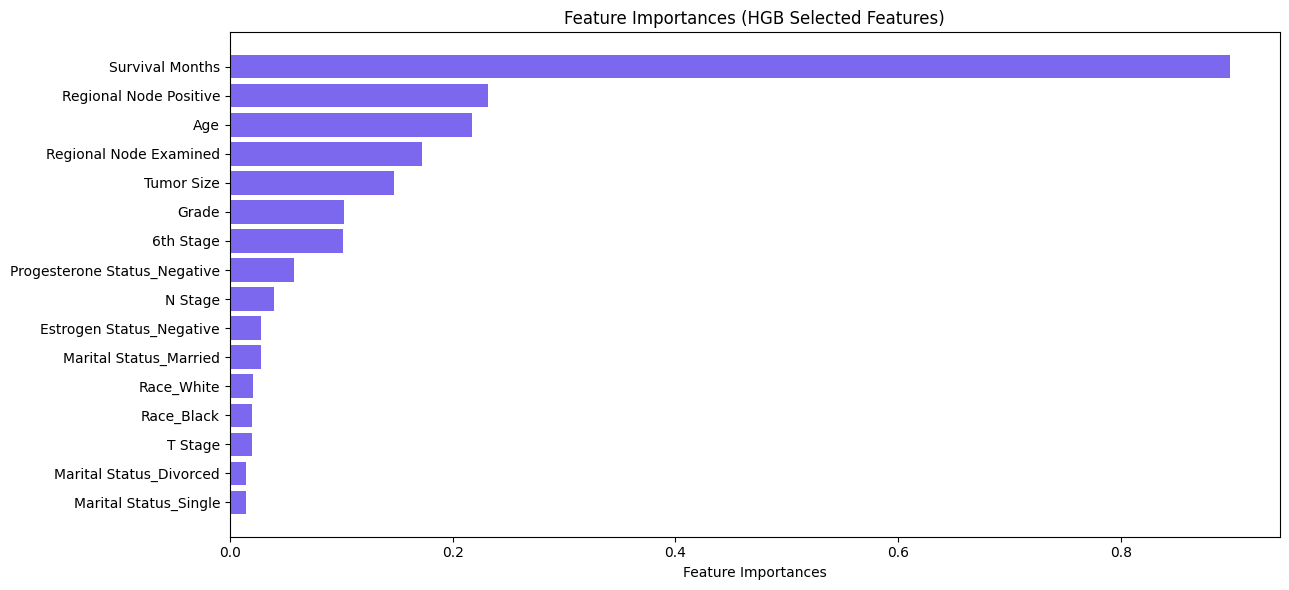

In [183]:
# Map feature names to their SHAP importance scores
feature_dict = dict(zip(X_train.columns, mean_abs_shap))

# Filter to only hgb_selected_features
filtered_feature = {feat: feature_dict[feat] for feat in hgb_selected_features}

# Sort features
sort_shap = sorted(filtered_feature.items(), key = lambda x: x[1], reverse = True)[:16]
features, scores = zip(*sort_shap)

# Plot
plt.figure(figsize = (13, 6))
plt.title("Feature Importances (HGB Selected Features)")
plt.barh(range(len(hgb_selected_features)), scores[::-1], color = "mediumslateblue", align = "center")
plt.yticks(range(len(hgb_selected_features)), features[::-1])
plt.xlabel("Feature Importances")
plt.tight_layout()
plt.show()

* Survival Months, Age, Regional Node Positive, Regional Node Examined, Tumor Size, Grade, and 6th Stage are the critical factors for our final model.

### Confusion Matrix

In [184]:
# Function to plot confusion matrix for the best final model
def plot_confusion_matrix_with_percentages(model, predictors, target, threshold):
    """
    Plot confusion matrix with counts and percentages.

    Parameters:
    - model: ML model
    - predictors: predictors
    - target: target variables
    - threshold: optimum threshold for best model performance

    Outcome:
    - Confusion Matrix display for the specified model
    """
    y_prob = model.predict_proba(predictors)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Call the sklearn version, not this function again
    cm = confusion_matrix(target, y_pred)
    total = cm.sum()

    labels = np.array([
        [f"{cm[i, j]}\n{cm[i, j]/total:.2%}" for j in range(2)]
        for i in range(2)
    ])

    plt.figure(figsize = (6, 5))
    sns.heatmap(cm, annot = labels, fmt = "", cbar = False)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

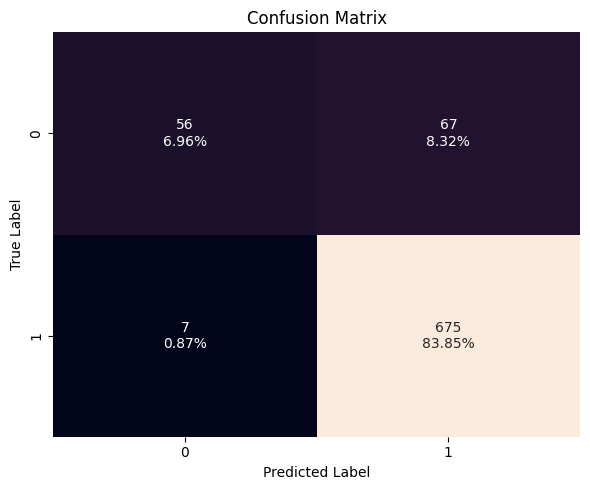

In [186]:
# Plot Confusion Matrix for the best model
plot_confusion_matrix_with_percentages(hgb_tuned, X_test, y_test, threshold = 0.366)

### Precision-Recall AUC

Precision-Recall AUC: 0.9667


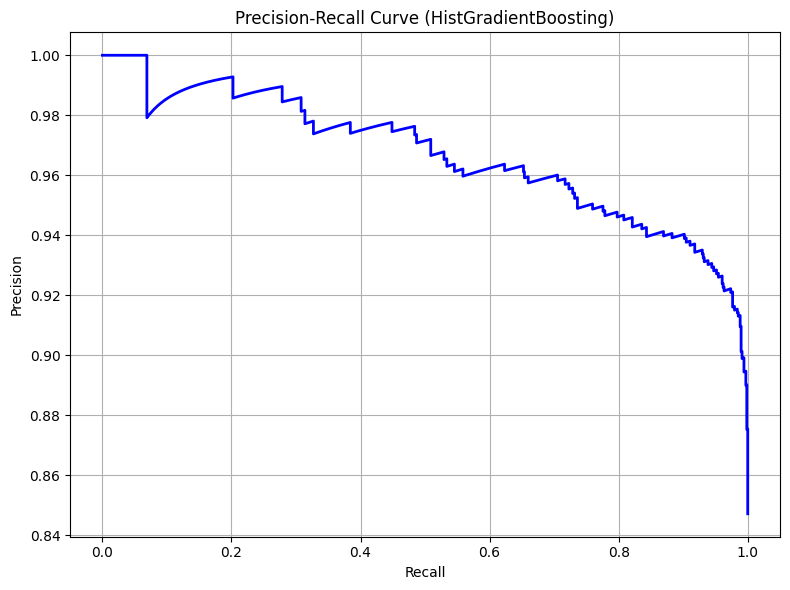

In [187]:
# Calculate Precision-Recall AUC for the final model
y_prob_hgb = hgb_tuned.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_prob_hgb)

print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_hgb)

# Plot PR Curve
plt.figure(figsize = (8, 6))
plt.plot(recall, precision, color = 'blue', lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (HistGradientBoosting)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Model Evaluation Report:

### **Confusion Matrix Summary**

* **True Positives (TP)**: 675 / 805 → **83.85%**
* **True Negatives (TN)**: 67 / 805 → **8.32%**
* **False Positives (FP)**: 56 / 805 → **6.96%**
* **False Negatives (FN)**: 7 / 805 → **0.87%**

---

### **Model Performance Summary**

* **Threshold Used**: 0.366
* **Accuracy**: 90.8%
* **Precision**: 91.0%
* **Recall**: 99.0%
* **F1 Score**: 94.8%
* **Precision-Recall AUC (across all thresholds)**: 96.67%

---

### **Interpretation**

* The model correctly classified 90.8% (67 + 675) of all test cases.
* It shows high recall, detecting the almost all of alive patients (99.0%).
* False negatives are minimal with only 7 cases.
* The model made 56 false alarms, predicting some deceased patients as alive.
* The Precision-Recall AUC of 96.67% confirms strong overall capability of the model in distinguishing the positive class (alive) across all thresholds.

---

### **Clinical Implications**

* High Recall (83.85%) rate makes the model effective in identifying patients likely to survive.
* The low false negative rate (0.87%) suggests strong potential for real-world deployment in healthcare settings where early detection and preventive intervention are crucial.
* The model’s PR AUC near 97% indicates its reliability even before threshold selection.

---

### **Final Recommendation**

The HistGradient Boosting model with tuned hyperparameters and an optimized threshold of 0.366 demonstrates robust classification performance with more than 90 percent overall. Based on its balanced tradeoff, very high recall, and low false negatives, it is well-suited as a final predictive model for breast cancer survival classification in this study. Its Precision-Recall AUC of 96.67% further reinforces its strength as a consistent and trustworthy model across varying thresholds.